# 0. SETUP

## 0.1. Módulos comuns

In [1]:
from numpy import *
from numpy.linalg import *
from matplotlib.pyplot import *
from matplotlib.collections import PatchCollection
from scipy.optimize import minimize

## 0.2. Módulos do projeto

In [2]:
from project_modules import graphics    # For plots
from project_modules import graph_utils # Graph manipulation
from project_modules import model_math  # The mathematical functions of the model

## 0.2. Parâmetros do problema

In [3]:
SCALE = 1.0        # How much each screen element is going to be scaled. Default is 1.0
SCREEN_HEIGHT = 30 # The height of the screen that contains the overlapping windows in pixels
SCREEN_WIDTH = 30  # The width of the screen that contains the overlapping windows in pixels
MAX_WINDOW_DIM = 3 # The max height or width each window can have. For the project the default is 3.
MIN_WINDOW_DIM = 2 # The minimum height or width each window can have. For the project the default is 2.
CLUSTER_DISTANCE_FROM_SCREEN_CENTER = 6 # The distance from the clusters to the screen center in pixels
POINT_DISTANCE_FROM_CLUSTER = 2         # How far the points can be from the cluster in pixels
KNN_K = 10         # The number of closest neighbors considered for building the connectivity graph
ALPHA = 0.0        # The weighting value for the energy function between E_N and E_O

## 0.3. Preprocessamento dos parâmetros

In [4]:
# Rescale
SCREEN_HEIGHT *= SCALE
SCREEN_WIDTH *= SCALE
MAX_WINDOW_DIM *= SCALE
MIN_WINDOW_DIM *= SCALE
CLUSTER_DISTANCE_FROM_SCREEN_CENTER *= SCALE
POINT_DISTANCE_FROM_CLUSTER *= SCALE
# Compute screen center
SCREEN_CENTER = array([ floor(SCREEN_WIDTH/2), floor(SCREEN_HEIGHT/2) ])
# Set a seed for reproducibility purposes
random.seed(7)

# 1. PREPARAÇÃO DOS DADOS

Os vetores $P_j$ gerados possuem dimensão $4$: a posição $x$ e $y$ (coluna) da origem do retângulo (ponto superior esquerdo), a altura do retângulo $h$ e a largura $w$, e o cluster $c_j$ ao qual ele pertence, de forma que $P_j=(x_j,y_j,h_j,w_j, c_j)$.

## 1.1 Gerar Centros

In [5]:
n_groups = random.randint(3,7)
angle_between_points = (2.0 * pi / n_groups * arange(0 , n_groups)) # The array of the angle of each cluster w.r.t. the x-axis
clusters = transpose( # Each row is a pair x,y from each cluster
    array( [
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * cos( angle_between_points ) + SCREEN_CENTER[0],
        CLUSTER_DISTANCE_FROM_SCREEN_CENTER * sin( angle_between_points ) + SCREEN_CENTER[1]
    ] )
)

## 1.2 Gerar pontos ao redor dos centros

In [6]:
size_groups = random.randint(5, 16, n_groups)
points = zeros((sum(size_groups),5)) # [x, y, w, h, label]
j = 0
for cluster_idx in range(n_groups):
    for idx in range(size_groups[cluster_idx]):
        # Point position
        points[j,:2] = clusters[cluster_idx] + random.randint(-POINT_DISTANCE_FROM_CLUSTER,POINT_DISTANCE_FROM_CLUSTER, 2)
        # Point dimension
        points[j,2:4] = random.randint(MIN_WINDOW_DIM,MAX_WINDOW_DIM+1,2)
        # cluster_information
        points[j,4] = cluster_idx
        j += 1
        
points_pos = points[:,:2] # position vectors
points_dims = points[:,2:4] # dimension vectors

## 1.3 Mostrar os dados

<Figure size 432x288 with 0 Axes>

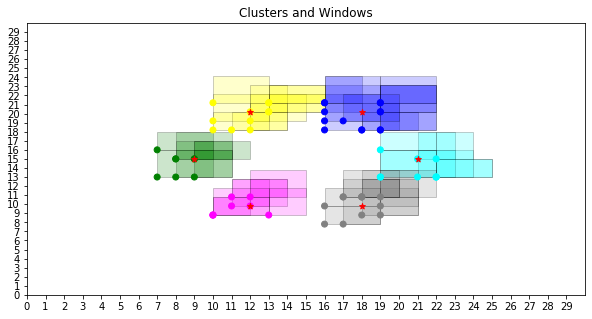

In [7]:
graphics.draw_windows(clusters, points_pos, points_dims, points[:,4], n_groups, size_groups, SCREEN_HEIGHT, SCREEN_WIDTH, SCALE)

# 2. Modelagem Matemática


O problema se resume a minimizar $E(X) = (1-\alpha) E_O(X) + \alpha E_N(X) $, em que $X=(x_j, y_j)$ e $\alpha \in [0,1]$. $E_0$ e $E_N$ são as funções de energia de overlap e a de relação entre os vizinhos. Mais detalhes sobre as funções podem ser encontradas [neste link](https://ieeexplore.ieee.org/abstract/document/6629989).

In [8]:
_LAPLACIAN_L = graph_utils.laplacian_graph(points_pos, K=KNN_K)
_DELTA_X = _LAPLACIAN_L.dot(points_pos[:,0])
_DELTA_Y = _LAPLACIAN_L.dot(points_pos[:,1])
def E_N(X):
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2)) # Removes w from the state
    e_n = model_math.E_N(X, w, _LAPLACIAN_L, _DELTA_X, _DELTA_Y)
    return e_n

def E_O(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    e_o = model_math.E_O(X, points_dims)
    return e_o

# 3. Solução Numérica

## 3.1 Função

In [9]:
alpha = ALPHA

def f (X):
    e_n = E_N(X)
    e_o = E_O(X)
    print("E_N(X)={} | E_O(X)={}".format(e_n, e_o) )
    return alpha * e_n + (1- alpha) * e_o

def jac_f(X):
    w = X[-1]
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    jac_E_O = model_math.jac_E_O(X, points_dims)
    jac_E_N = 0 # TODO TODO TODO TODO TODO TODO
    jac_E = alpha * jac_E_N + (1.0-alpha) * jac_E_O
    jac_E = append(jac_E, [0.0])
    return jac_E

## 3.2 Restrições

A implementação das restrições foi adapatada para as condições do SciPy nas quais as desigualdades são do tipo $r_i(X) \geq 0$ [(fonte)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

In [10]:
x_min = 0; x_max = SCREEN_WIDTH
y_min = 0; y_max = SCREEN_HEIGHT

# r1: x_min-x_i <= 0 <=> x_i - x_min >= 0
def constr_fun_1(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_1(X, x_min)

# r2: x_i - x_max + h_i <= 0 <=> x_max - x_i - h_i >= 0
def constr_fun_2(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_2(X, x_max, points_dims)

# r3: y_min-y_i <= 0 <=> y_i - y_min >= 0
def constr_fun_3(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_3(X, y_min)

# r4: y_i - y_max + v_i <= 0 <=> y_max - y_i - v_i >= 0
def constr_fun_4(X):
    X = reshape(X[:-1], (points.shape[0], 2)) # Remove w from the state
    return model_math.constr_fun_4(X,y_max, points_dims)

cons = (
    {'type': 'ineq', 'fun':  constr_fun_1},
    {'type': 'ineq', 'fun':  constr_fun_2},
    {'type': 'ineq', 'fun':  constr_fun_3},
    {'type': 'ineq', 'fun':  constr_fun_4},
)

## 3.3 Minimização

In [11]:
w_init = 1.0
X_init = append(points_pos.flatten(), [w_init])

use_grad = True

res = None
if(use_grad):
    res = minimize(
        f, X_init, 
        method='SLSQP', 
        jac=jac_f,
        constraints=cons, 
        tol=1e-9, 
        options={"maxiter" : 1e3}
    )
    
else:
    res = minimize(
        f, X_init, 
        method='SLSQP', 
        constraints=cons, 
        tol=1e-9, 
        options={"maxiter" : 1e2}
    )

X_final = reshape(res["x"][:-1], (points.shape[0], 2))

E_N(X)=0.0 | E_O(X)=0.0442759202949674
E_N(X)=2541.7226544561117 | E_O(X)=0.023985353787050908
E_N(X)=635.6598395980058 | E_O(X)=0.026013218678510662
E_N(X)=159.01813673907853 | E_O(X)=0.032199220405203226
E_N(X)=39.788664832725814 | E_O(X)=0.03768241703333473
E_N(X)=9.956487892965974 | E_O(X)=0.04089344845007325
E_N(X)=2.4915141516645893 | E_O(X)=0.042569533076284374
E_N(X)=0.6234822337996029 | E_O(X)=0.04341953928447973
E_N(X)=0.15602212000112625 | E_O(X)=0.043846929237174107
E_N(X)=0.039043509718341106 | E_O(X)=0.04406118483667717
E_N(X)=0.009770387610933297 | E_O(X)=0.04416846795020771
E_N(X)=0.002444977481187313 | E_O(X)=0.044222160058410426
E_N(X)=82209.25837682368 | E_O(X)=0.014733721024489025
E_N(X)=20561.093523443156 | E_O(X)=0.022247726819492594
E_N(X)=5144.411022652629 | E_O(X)=0.02300515003010721
E_N(X)=1288.1601464034213 | E_O(X)=0.022961654546793404
E_N(X)=323.070433061432 | E_O(X)=0.028369657991179742
E_N(X)=81.26120397353812 | E_O(X)=0.03521809638147286
E_N(X)=20.548702

E_N(X)=4483.423957313137 | E_O(X)=0.025341438593381064
E_N(X)=1277.6595586716821 | E_O(X)=0.02332423085904288
E_N(X)=405.8397353500823 | E_O(X)=0.027827724658053863
E_N(X)=152.6477687704894 | E_O(X)=0.033066726786575816
E_N(X)=71.72921523005338 | E_O(X)=0.036347704540875735
E_N(X)=42.69205410516861 | E_O(X)=0.038061816079762556
E_N(X)=31.029380337053432 | E_O(X)=0.03892551788863093
E_N(X)=25.911642620007648 | E_O(X)=0.039357658424452435
E_N(X)=266243.4456869723 | E_O(X)=0.020370763824599795
E_N(X)=67835.89697766751 | E_O(X)=0.01785963482947615
E_N(X)=17606.428108059194 | E_O(X)=0.032839345598844834
E_N(X)=4734.533944480647 | E_O(X)=0.02461051531914546
E_N(X)=1359.9916096440725 | E_O(X)=0.02267561726546078
E_N(X)=437.9453005724618 | E_O(X)=0.027420429797880428
E_N(X)=168.17701388380294 | E_O(X)=0.032592260051296805
E_N(X)=81.10531640722262 | E_O(X)=0.03588614716295271
E_N(X)=49.52489407991465 | E_O(X)=0.03761326778045984
E_N(X)=36.72376966899229 | E_O(X)=0.038484805802391345
E_N(X)=31.0

E_N(X)=216.67115888604778 | E_O(X)=0.03133732872081227
E_N(X)=164.49940456503265 | E_O(X)=0.03272173170137365
E_N(X)=141.6070802747073 | E_O(X)=0.0334299873515072
E_N(X)=130.95763366488043 | E_O(X)=0.03378686615070951
E_N(X)=273316.3837328836 | E_O(X)=0.019072335320361178
E_N(X)=70990.5366413406 | E_O(X)=0.01861539688287318
E_N(X)=19127.586279479114 | E_O(X)=0.026623340293288222
E_N(X)=5520.64258459395 | E_O(X)=0.021994856721326554
E_N(X)=1798.818345799719 | E_O(X)=0.02053302987584936
E_N(X)=708.2319716371354 | E_O(X)=0.0248050463003495
E_N(X)=355.4466470705279 | E_O(X)=0.02861475882929864
E_N(X)=227.1749814725194 | E_O(X)=0.031068571316005697
E_N(X)=175.06610814267265 | E_O(X)=0.03240616570585847
E_N(X)=152.0158256740596 | E_O(X)=0.03309252225987492
E_N(X)=141.23994165577636 | E_O(X)=0.033438759663159776
E_N(X)=252871.593362859 | E_O(X)=0.018006152083184672
E_N(X)=65886.8914539899 | E_O(X)=0.017816587782545877
E_N(X)=17859.287348357542 | E_O(X)=0.02781287033058977
E_N(X)=5211.14712363

E_N(X)=17969.094760856548 | E_O(X)=0.025030471797540914
E_N(X)=5547.273034536389 | E_O(X)=0.019969541448279254
E_N(X)=2023.7821986139052 | E_O(X)=0.020230213684590524
E_N(X)=933.7373676259749 | E_O(X)=0.02333326245735624
E_N(X)=556.586084515918 | E_O(X)=0.02622860699687454
E_N(X)=409.9631520442587 | E_O(X)=0.027860242530514355
E_N(X)=347.1355767950536 | E_O(X)=0.028748403057217663
E_N(X)=318.3388388953494 | E_O(X)=0.029215101938194345
E_N(X)=304.5922799167 | E_O(X)=0.02945389268240025
E_N(X)=228556.54111851193 | E_O(X)=0.016543425836148404
E_N(X)=60653.84303214935 | E_O(X)=0.022736182068130915
E_N(X)=17034.458644623643 | E_O(X)=0.02390930881968089
E_N(X)=5308.3242346205225 | E_O(X)=0.019361273941345514
E_N(X)=1966.3785953697222 | E_O(X)=0.0201295349655061
E_N(X)=925.5392151610514 | E_O(X)=0.02321742843036997
E_N(X)=562.6076759108988 | E_O(X)=0.02605072129450659
E_N(X)=420.49916250385473 | E_O(X)=0.027658334592923727
E_N(X)=359.27956709072265 | E_O(X)=0.028528600723487136
E_N(X)=331.124

E_N(X)=2282.3468181193293 | E_O(X)=0.019756440631972835
E_N(X)=1172.5494765910269 | E_O(X)=0.02163994442779738
E_N(X)=773.4444338417733 | E_O(X)=0.023926409957910337
E_N(X)=612.813534474139 | E_O(X)=0.025331563368119623
E_N(X)=542.2196484821291 | E_O(X)=0.026072545100584085
E_N(X)=509.34811269186207 | E_O(X)=0.02644711242036983
E_N(X)=493.5158447005228 | E_O(X)=0.026634824912301916
E_N(X)=174866.0244029305 | E_O(X)=0.013497137242543528
E_N(X)=47467.07632604484 | E_O(X)=0.012859423737314735
E_N(X)=13927.379290216246 | E_O(X)=0.024297993299507423
E_N(X)=4696.587110876584 | E_O(X)=0.01915124505557305
E_N(X)=1966.847834720365 | E_O(X)=0.019412363223246902
E_N(X)=1073.2235836915795 | E_O(X)=0.02187908402069867
E_N(X)=744.1666604485522 | E_O(X)=0.024044206216597162
E_N(X)=609.0584281135842 | E_O(X)=0.02530721458031222
E_N(X)=548.8515309774564 | E_O(X)=0.0259671942901623
E_N(X)=520.580264337087 | E_O(X)=0.026300613818232656
E_N(X)=506.9000640022992 | E_O(X)=0.02646761259154366
E_N(X)=206260.8

E_N(X)=42967.63263207626 | E_O(X)=0.01649903652166863
E_N(X)=12950.000518363739 | E_O(X)=0.02480922474660778
E_N(X)=4588.882401253707 | E_O(X)=0.018991865967998605
E_N(X)=2071.111042465312 | E_O(X)=0.01886330956513475
E_N(X)=1227.7173034339855 | E_O(X)=0.02084752976119403
E_N(X)=909.8293364237702 | E_O(X)=0.02265047221282942
E_N(X)=776.8152233199164 | E_O(X)=0.02367244033242672
E_N(X)=716.7821746676833 | E_O(X)=0.024200831867049185
E_N(X)=688.3792101632056 | E_O(X)=0.024468788043064706
E_N(X)=674.5783169791354 | E_O(X)=0.024603455806819576
E_N(X)=163879.4091488946 | E_O(X)=0.015253730365984335
E_N(X)=45035.89119765513 | E_O(X)=0.017102519369506918
E_N(X)=13544.851522004159 | E_O(X)=0.025565385974410937
E_N(X)=4781.523143784083 | E_O(X)=0.019014401994618207
E_N(X)=2146.346344440398 | E_O(X)=0.01870943094497946
E_N(X)=1265.1483158979563 | E_O(X)=0.020658901308237557
E_N(X)=933.5785680061679 | E_O(X)=0.02247691544047998
E_N(X)=795.0273696352656 | E_O(X)=0.023516891021545267
E_N(X)=732.551

E_N(X)=853.0739835346168 | E_O(X)=0.022870048677348147
E_N(X)=152492.94249544546 | E_O(X)=0.015169324701239389
E_N(X)=42538.944643599985 | E_O(X)=0.018714422299948692
E_N(X)=13162.080587315904 | E_O(X)=0.022008070606761413
E_N(X)=4873.867035656925 | E_O(X)=0.017875306172731174
E_N(X)=2330.325703766868 | E_O(X)=0.017393954786915668
E_N(X)=1458.5482992696595 | E_O(X)=0.019090182318343574
E_N(X)=1122.581059861287 | E_O(X)=0.020767819820461587
E_N(X)=979.5475343624004 | E_O(X)=0.021796599798576052
E_N(X)=914.2549791628861 | E_O(X)=0.022330461696143798
E_N(X)=883.1580868253026 | E_O(X)=0.022599510138269777
E_N(X)=867.993352744184 | E_O(X)=0.022734569879276575
E_N(X)=155798.67473674548 | E_O(X)=0.016199758300599353
E_N(X)=43443.034072373855 | E_O(X)=0.01838665801671824
E_N(X)=13432.718259798892 | E_O(X)=0.022509168401554668
E_N(X)=4969.344689101942 | E_O(X)=0.018224262288553467
E_N(X)=2373.700896259533 | E_O(X)=0.01736579273919082
E_N(X)=1484.7495770173564 | E_O(X)=0.018955732490635372
E_N(X

E_N(X)=2928.122048688936 | E_O(X)=0.017165350702006404
E_N(X)=1827.2756821500263 | E_O(X)=0.01796491936983239
E_N(X)=1404.6315274524347 | E_O(X)=0.019163387389134603
E_N(X)=1225.2194869702355 | E_O(X)=0.02006433345086829
E_N(X)=1143.4727717754147 | E_O(X)=0.020570078511484485
E_N(X)=1104.5806175369821 | E_O(X)=0.020831570079475666
E_N(X)=1085.6253577434204 | E_O(X)=0.02096411779263765
E_N(X)=188936.20073775557 | E_O(X)=0.01626084047388707
E_N(X)=52764.93527122186 | E_O(X)=0.020934900136253654
E_N(X)=16362.957754840216 | E_O(X)=0.022763271734039733
E_N(X)=6083.489638612411 | E_O(X)=0.019018720907781735
E_N(X)=2924.6040706047024 | E_O(X)=0.01719599453047954
E_N(X)=1840.2877285450768 | E_O(X)=0.017950578525064417
E_N(X)=1421.8195850385362 | E_O(X)=0.019097020274053356
E_N(X)=1243.473991212609 | E_O(X)=0.01996179891833571
E_N(X)=1162.005372256001 | E_O(X)=0.020451199680856395
E_N(X)=1123.1884870525005 | E_O(X)=0.020705150451513093
E_N(X)=1104.2549401328927 | E_O(X)=0.02083401061521714
E_N(

E_N(X)=104075.34400167488 | E_O(X)=0.013621681072328598
E_N(X)=31080.556386342923 | E_O(X)=0.020863400122816157
E_N(X)=10804.987822146784 | E_O(X)=0.017103791346320552
E_N(X)=4723.968564498574 | E_O(X)=0.01659510633423192
E_N(X)=2697.426694028065 | E_O(X)=0.01617079251505561
E_N(X)=1937.6520608368608 | E_O(X)=0.017065649697475555
E_N(X)=1621.082310293885 | E_O(X)=0.018068562045846216
E_N(X)=1478.5956062923779 | E_O(X)=0.01868690938599506
E_N(X)=1411.2882467969416 | E_O(X)=0.019024928618895737
E_N(X)=1378.6113609148647 | E_O(X)=0.019200280157545678
E_N(X)=1362.5133707978869 | E_O(X)=0.01928941733879103
E_N(X)=146325.96220745682 | E_O(X)=0.015908426699964187
E_N(X)=42403.54446451645 | E_O(X)=0.025692053736507132
E_N(X)=14021.070900934881 | E_O(X)=0.021826016213017274
E_N(X)=5726.547702985732 | E_O(X)=0.01771136773909774
E_N(X)=3053.4729328304484 | E_O(X)=0.01640707903361019
E_N(X)=2085.366038394094 | E_O(X)=0.016902254398486628
E_N(X)=1693.354052039412 | E_O(X)=0.017871947647601995
E_N(X

E_N(X)=1834.8331470283426 | E_O(X)=0.017455457291855374
E_N(X)=1729.1592617578476 | E_O(X)=0.017772250725526198
E_N(X)=1678.1628407458545 | E_O(X)=0.017941116718372573
E_N(X)=1653.1200358137287 | E_O(X)=0.018027919397908716
E_N(X)=196799.89256368903 | E_O(X)=0.018755289421335822
E_N(X)=56959.69477374909 | E_O(X)=0.02020532147854268
E_N(X)=18739.324509881604 | E_O(X)=0.025933992677359737
E_N(X)=7553.506951065448 | E_O(X)=0.0187610460007844
E_N(X)=3943.035055941899 | E_O(X)=0.01680063575591193
E_N(X)=2633.1330850434083 | E_O(X)=0.01649001779446517
E_N(X)=2101.9639159405674 | E_O(X)=0.016879581383233665
E_N(X)=1867.2924507277396 | E_O(X)=0.017370782377117148
E_N(X)=1757.6634628194215 | E_O(X)=0.017683717672477547
E_N(X)=1704.7658205216062 | E_O(X)=0.017852306571280063
E_N(X)=1678.7914103598837 | E_O(X)=0.01793924408464488
E_N(X)=182078.00400846265 | E_O(X)=0.017808836263456404
E_N(X)=53103.23574068471 | E_O(X)=0.02053288753021042
E_N(X)=17696.5938288854 | E_O(X)=0.024224865941380166
E_N(X

E_N(X)=2057.097600954778 | E_O(X)=0.016630800777145172
E_N(X)=1973.4614111520373 | E_O(X)=0.016911395791228696
E_N(X)=1932.8981619110116 | E_O(X)=0.017064488750735223
E_N(X)=1912.9258741829217 | E_O(X)=0.01714393210270288
E_N(X)=1903.014839669937 | E_O(X)=0.01718437070987601
E_N(X)=49596.24872408216 | E_O(X)=0.018299778205674154
E_N(X)=16737.56606981977 | E_O(X)=0.019519238940893333
E_N(X)=7067.05604276055 | E_O(X)=0.014816550717684384
E_N(X)=3922.0912050015168 | E_O(X)=0.014765909019855188
E_N(X)=2771.9190580411173 | E_O(X)=0.01547615976910802
E_N(X)=2302.361895043878 | E_O(X)=0.01610122775898019
E_N(X)=2093.9450467594506 | E_O(X)=0.016548094796425692
E_N(X)=1996.3131324862259 | E_O(X)=0.016842934981177383
E_N(X)=1949.1319754008491 | E_O(X)=0.017008413373987986
E_N(X)=1925.9453050094194 | E_O(X)=0.017095117507277675
E_N(X)=1914.4505211762605 | E_O(X)=0.017139416598397263
E_N(X)=53224.99124267437 | E_O(X)=0.018581126291341458
E_N(X)=17778.48461073142 | E_O(X)=0.019479220431035567
E_N(X

E_N(X)=2789.1559342367004 | E_O(X)=0.015568049350783337
E_N(X)=2439.3827168326793 | E_O(X)=0.015992011282887148
E_N(X)=2278.5976188382333 | E_O(X)=0.01624670998024864
E_N(X)=2201.7214926805946 | E_O(X)=0.016389623348808037
E_N(X)=2164.1574689494123 | E_O(X)=0.01646726467896136
E_N(X)=2145.59118745432 | E_O(X)=0.016507665868086416
E_N(X)=103989.26912266496 | E_O(X)=0.012477250974017206
E_N(X)=32466.829786059552 | E_O(X)=0.02639023814100614
E_N(X)=12153.26647661322 | E_O(X)=0.019353986740430013
E_N(X)=5861.682790909209 | E_O(X)=0.014512603465624142
E_N(X)=3682.06526717942 | E_O(X)=0.014812352506986107
E_N(X)=2833.51261353428 | E_O(X)=0.015500541220775153
E_N(X)=2469.5070563106606 | E_O(X)=0.0159448081615316
E_N(X)=2302.5574028777287 | E_O(X)=0.016204776259202674
E_N(X)=2222.8369931982797 | E_O(X)=0.016348623717509135
E_N(X)=2183.9103663368332 | E_O(X)=0.016426161771622184
E_N(X)=2164.677690451316 | E_O(X)=0.016466396592777148
E_N(X)=67426.97499144461 | E_O(X)=0.014552206696710963
E_N(X)=

E_N(X)=2420.9927215764674 | E_O(X)=0.015944885145829844
E_N(X)=2386.6689293786376 | E_O(X)=0.016008061026644906
E_N(X)=2369.6860722213137 | E_O(X)=0.016040002538238864
E_N(X)=91792.02266644749 | E_O(X)=0.013210691873602711
E_N(X)=29315.777113313692 | E_O(X)=0.01775289883342485
E_N(X)=11400.643046857509 | E_O(X)=0.015006953784073044
E_N(X)=5774.943371830797 | E_O(X)=0.013282538365827988
E_N(X)=3795.0030687564367 | E_O(X)=0.014205204162574574
E_N(X)=3013.084067496401 | E_O(X)=0.015052981144391657
E_N(X)=2674.1010626758884 | E_O(X)=0.015524470760598109
E_N(X)=2517.59012526605 | E_O(X)=0.015775646367686726
E_N(X)=2442.571584278091 | E_O(X)=0.015906155933671368
E_N(X)=2405.8670075937503 | E_O(X)=0.015972701143517384
E_N(X)=2387.713521234136 | E_O(X)=0.016006213969401398
E_N(X)=91538.8679612752 | E_O(X)=0.013306829212417149
E_N(X)=29287.78067264159 | E_O(X)=0.018456363399178097
E_N(X)=11417.912704273858 | E_O(X)=0.015094353209261353
E_N(X)=5798.204006005113 | E_O(X)=0.013291001546659721
E_N(

E_N(X)=7954.901453585225 | E_O(X)=0.011729867589825353
E_N(X)=4724.684875384247 | E_O(X)=0.01223334963481268
E_N(X)=3514.4989877400576 | E_O(X)=0.013638401831580925
E_N(X)=3010.5475600656155 | E_O(X)=0.0146070716119098
E_N(X)=2783.8265810181315 | E_O(X)=0.015113511768388826
E_N(X)=2676.7662578637505 | E_O(X)=0.015363536805767419
E_N(X)=2624.804030054611 | E_O(X)=0.015487280181082499
E_N(X)=2599.2111086453638 | E_O(X)=0.015548735309213794
E_N(X)=2586.509741138585 | E_O(X)=0.015579425890460626
E_N(X)=49795.01084585112 | E_O(X)=0.017419899395516428
E_N(X)=17603.568960325156 | E_O(X)=0.014340359620716208
E_N(X)=7948.626970697272 | E_O(X)=0.011710144884926726
E_N(X)=4731.317920540269 | E_O(X)=0.01222578572589062
E_N(X)=3524.9981624258753 | E_O(X)=0.0136133035837204
E_N(X)=3022.3345001113416 | E_O(X)=0.014577414755487865
E_N(X)=2796.0957892839056 | E_O(X)=0.015083316355422835
E_N(X)=2689.23607718977 | E_O(X)=0.015333109103292069
E_N(X)=2637.3640050945182 | E_O(X)=0.015456775837445208
E_N(X)=

E_N(X)=4884.987824366482 | E_O(X)=0.01191608340349744
E_N(X)=3678.7321785874706 | E_O(X)=0.01325204515978588
E_N(X)=3179.315512000434 | E_O(X)=0.014159613839729874
E_N(X)=2955.507017070495 | E_O(X)=0.014669934231090942
E_N(X)=2850.0626395979825 | E_O(X)=0.014926242497317556
E_N(X)=2798.947951623741 | E_O(X)=0.01505304439070877
E_N(X)=2773.788582660852 | E_O(X)=0.015116013083901977
E_N(X)=2761.306376915961 | E_O(X)=0.01514738199058357
E_N(X)=55449.508121050945 | E_O(X)=0.014882889649835956
E_N(X)=19254.585056964876 | E_O(X)=0.013166645144881951
E_N(X)=8545.543967824266 | E_O(X)=0.011219579805853707
E_N(X)=5038.156978905867 | E_O(X)=0.011990241675601584
E_N(X)=3746.0433918025856 | E_O(X)=0.013228750016420225
E_N(X)=3215.3141246001046 | E_O(X)=0.014120626200909637
E_N(X)=2978.7517051648288 | E_O(X)=0.014631523033060943
E_N(X)=2867.655449427165 | E_O(X)=0.01489124581093546
E_N(X)=2813.8957698291583 | E_O(X)=0.015019883563149707
E_N(X)=2787.459010097672 | E_O(X)=0.015083784469492626
E_N(X)=

E_N(X)=3429.1631926155237 | E_O(X)=0.013726756589632488
E_N(X)=3175.685444893572 | E_O(X)=0.014209753534739576
E_N(X)=3056.7869560579784 | E_O(X)=0.014463844413843546
E_N(X)=2999.2891865787046 | E_O(X)=0.014593403498064064
E_N(X)=2971.0236152031816 | E_O(X)=0.014658396599962485
E_N(X)=2957.009330116131 | E_O(X)=0.014690853085220659
E_N(X)=61478.05438363411 | E_O(X)=0.011509246982129613
E_N(X)=21167.273020275334 | E_O(X)=0.011843109128086704
E_N(X)=9299.690682680906 | E_O(X)=0.011272725706388804
E_N(X)=5437.9712259775 | E_O(X)=0.01163596290460524
E_N(X)=4025.04871571622 | E_O(X)=0.012799538096707938
E_N(X)=3447.9857527850277 | E_O(X)=0.013679771054634644
E_N(X)=3191.7704139252937 | E_O(X)=0.014170242441548428
E_N(X)=3071.726236752778 | E_O(X)=0.014427658927710333
E_N(X)=3013.711300519758 | E_O(X)=0.014558960356878274
E_N(X)=2985.2009889450806 | E_O(X)=0.014624937266791918
E_N(X)=2971.067746656124 | E_O(X)=0.01465790574419649
E_N(X)=61421.067073350074 | E_O(X)=0.012227553451076862
E_N(X)

E_N(X)=61395.67741582033 | E_O(X)=0.011616885593945421
E_N(X)=21236.28689546342 | E_O(X)=0.011792584045569694
E_N(X)=9427.529984806406 | E_O(X)=0.01169994121146378
E_N(X)=5590.924853362054 | E_O(X)=0.01123015555885605
E_N(X)=4189.610395126364 | E_O(X)=0.012249895289956092
E_N(X)=3618.078286334208 | E_O(X)=0.013215625554218317
E_N(X)=3364.5448519821484 | E_O(X)=0.013747397123511385
E_N(X)=3245.8184616632225 | E_O(X)=0.014013148929803265
E_N(X)=3188.4562505672743 | E_O(X)=0.014145551796044934
E_N(X)=3160.270487763206 | E_O(X)=0.01421158771164847
E_N(X)=3146.298896251292 | E_O(X)=0.01424454964551312
E_N(X)=62480.889354801984 | E_O(X)=0.011296306392666955
E_N(X)=21576.124251642497 | E_O(X)=0.011744449773481543
E_N(X)=9551.930218143276 | E_O(X)=0.011664292779642827
E_N(X)=5646.9577387975 | E_O(X)=0.011152698408939126
E_N(X)=4221.303633264819 | E_O(X)=0.012179909355023277
E_N(X)=3640.058526579661 | E_O(X)=0.013164473611238604
E_N(X)=3382.280933580577 | E_O(X)=0.01370549773335804
E_N(X)=3261.

E_N(X)=82703.73446737199 | E_O(X)=0.01616577363090502
E_N(X)=27464.17509432649 | E_O(X)=0.014085470350386304
E_N(X)=11510.314996418452 | E_O(X)=0.012522087177529825
E_N(X)=6449.743664960367 | E_O(X)=0.011396220211254807
E_N(X)=4648.531857634961 | E_O(X)=0.011787485189485985
E_N(X)=3930.0768313183257 | E_O(X)=0.012649298809993909
E_N(X)=3616.315522114158 | E_O(X)=0.013214768858153375
E_N(X)=3470.775106247966 | E_O(X)=0.013508992977471428
E_N(X)=3400.8280112413513 | E_O(X)=0.01365657205842325
E_N(X)=3366.553972741312 | E_O(X)=0.01373024131345861
E_N(X)=3349.588574331601 | E_O(X)=0.013767022665949796
E_N(X)=69845.75121439755 | E_O(X)=0.012192505730111481
E_N(X)=23915.25834119724 | E_O(X)=0.01253902263849058
E_N(X)=10461.84534337845 | E_O(X)=0.012125619283448512
E_N(X)=6113.221615355359 | E_O(X)=0.011152912215712546
E_N(X)=4533.513549428425 | E_O(X)=0.011779661867751262
E_N(X)=3892.1863053529482 | E_O(X)=0.012660262380323114
E_N(X)=3608.592922120409 | E_O(X)=0.013204774025308548
E_N(X)=347

E_N(X)=4223.868969629649 | E_O(X)=0.012193614205120247
E_N(X)=3877.125157428404 | E_O(X)=0.012705436339745217
E_N(X)=3716.7440674201853 | E_O(X)=0.01299669377023917
E_N(X)=3639.786615384005 | E_O(X)=0.01314790957528889
E_N(X)=3602.108734229023 | E_O(X)=0.013223954699677016
E_N(X)=3583.466233683046 | E_O(X)=0.013262007195618401
E_N(X)=92592.09275139384 | E_O(X)=0.012095207850766556
E_N(X)=30527.57657760155 | E_O(X)=0.013696438013379195
E_N(X)=12665.088160981952 | E_O(X)=0.013420484032258385
E_N(X)=7026.690294642939 | E_O(X)=0.011705248845989308
E_N(X)=5030.92804949779 | E_O(X)=0.01154914641018866
E_N(X)=4238.799402167191 | E_O(X)=0.012162490311609786
E_N(X)=3894.095015024759 | E_O(X)=0.01267001764674069
E_N(X)=3734.5507175170983 | E_O(X)=0.012959070851989588
E_N(X)=3657.96605536436 | E_O(X)=0.013109721709372212
E_N(X)=3620.4631813217475 | E_O(X)=0.013185813139053945
E_N(X)=3601.9053279559926 | E_O(X)=0.013223891356363088
E_N(X)=92226.06247203589 | E_O(X)=0.011447632636621243
E_N(X)=3045

E_N(X)=3862.8345708940583 | E_O(X)=0.012614865128931724
E_N(X)=3812.740727348106 | E_O(X)=0.012735185665547025
E_N(X)=3788.0842104038716 | E_O(X)=0.012796017586399836
E_N(X)=3775.8509568679733 | E_O(X)=0.012826520919422994
E_N(X)=60111.72419560611 | E_O(X)=0.00979716973197505
E_N(X)=21247.616537596572 | E_O(X)=0.009650221781573863
E_N(X)=9837.92934914018 | E_O(X)=0.010644824540194353
E_N(X)=6138.493209844911 | E_O(X)=0.0104946028860166
E_N(X)=4790.238833190068 | E_O(X)=0.011090034201913089
E_N(X)=4241.404751941154 | E_O(X)=0.011842949089556172
E_N(X)=3998.260545659897 | E_O(X)=0.012324249636306647
E_N(X)=3884.4848415136685 | E_O(X)=0.012572510598662419
E_N(X)=3829.536170464663 | E_O(X)=0.012698627165576827
E_N(X)=3802.5412817300553 | E_O(X)=0.012762358072360877
E_N(X)=3789.160908026351 | E_O(X)=0.012794414839707662
E_N(X)=62262.54627874424 | E_O(X)=0.010334613909017113
E_N(X)=21842.456404993263 | E_O(X)=0.009584862316839797
E_N(X)=10020.305758921168 | E_O(X)=0.010634720406035929
E_N(X)

E_N(X)=10066.829352682109 | E_O(X)=0.009236817179984307
E_N(X)=6393.601741705205 | E_O(X)=0.009988776612816828
E_N(X)=5011.6731866255595 | E_O(X)=0.010581031936667035
E_N(X)=4434.36050303144 | E_O(X)=0.011389254349471965
E_N(X)=4174.068397936131 | E_O(X)=0.011905339250727332
E_N(X)=4050.9926047681897 | E_O(X)=0.012183384203727278
E_N(X)=3991.211944531302 | E_O(X)=0.012327948793369015
E_N(X)=3961.7554466848333 | E_O(X)=0.012401491052255671
E_N(X)=3947.132849694131 | E_O(X)=0.012438562365732613
E_N(X)=3939.8465413880485 | E_O(X)=0.01245717162671564
E_N(X)=26247.5578421058 | E_O(X)=0.010221840058547075
E_N(X)=11641.47029157851 | E_O(X)=0.009621061391634779
E_N(X)=6927.816645969869 | E_O(X)=0.009970206014615185
E_N(X)=5218.249072826481 | E_O(X)=0.01048710866242322
E_N(X)=4525.249397714537 | E_O(X)=0.011249881766889342
E_N(X)=4219.14819969825 | E_O(X)=0.011820959277072404
E_N(X)=4076.171305744438 | E_O(X)=0.012130575824482518
E_N(X)=4007.18989255277 | E_O(X)=0.012291629690578358
E_N(X)=3973

E_N(X)=5216.168466407676 | E_O(X)=0.010802883821264788
E_N(X)=4614.465012909817 | E_O(X)=0.011239513792369598
E_N(X)=4346.067313864316 | E_O(X)=0.011612275676741819
E_N(X)=4219.959515731408 | E_O(X)=0.011851634829232785
E_N(X)=4158.915822997645 | E_O(X)=0.011974198463721792
E_N(X)=4128.891056621165 | E_O(X)=0.01203584086559391
E_N(X)=4114.000148755304 | E_O(X)=0.012066740153412067
E_N(X)=64370.42273123468 | E_O(X)=0.010460587421218817
E_N(X)=22988.333697141104 | E_O(X)=0.011156444967795753
E_N(X)=10737.648770200227 | E_O(X)=0.010275571495490613
E_N(X)=6722.652757149557 | E_O(X)=0.010100570846788667
E_N(X)=5242.682144468022 | E_O(X)=0.010780749489179136
E_N(X)=4634.492866195119 | E_O(X)=0.011221336187318237
E_N(X)=4363.329808276352 | E_O(X)=0.011584843874547987
E_N(X)=4235.959629766483 | E_O(X)=0.01182177495970395
E_N(X)=4174.314726580898 | E_O(X)=0.011943863871051973
E_N(X)=4143.9968013631005 | E_O(X)=0.012005214320144253
E_N(X)=4128.961175084086 | E_O(X)=0.012035953098245858
E_N(X)=62

E_N(X)=4569.6942671265915 | E_O(X)=0.011245946140418054
E_N(X)=4437.3218652573905 | E_O(X)=0.01145192743153868
E_N(X)=4373.114286780516 | E_O(X)=0.011562933307356487
E_N(X)=4341.499061839075 | E_O(X)=0.011620411279058428
E_N(X)=4325.810468735408 | E_O(X)=0.011649323600674165
E_N(X)=67421.80376769426 | E_O(X)=0.008325794044238229
E_N(X)=24159.421496478433 | E_O(X)=0.009565787628746542
E_N(X)=11313.961160714607 | E_O(X)=0.010770189115567125
E_N(X)=7087.666522192604 | E_O(X)=0.009951791024270506
E_N(X)=5523.8765744533675 | E_O(X)=0.010280595192154681
E_N(X)=4879.224341413321 | E_O(X)=0.010805301962203528
E_N(X)=4591.16206512865 | E_O(X)=0.011190717683473267
E_N(X)=4455.672481076568 | E_O(X)=0.011409956783549457
E_N(X)=4390.051060348231 | E_O(X)=0.011527200105011782
E_N(X)=4357.764793780774 | E_O(X)=0.011587823943506829
E_N(X)=4341.749471032694 | E_O(X)=0.01161855460953653
E_N(X)=69872.36596012718 | E_O(X)=0.008333322871956794
E_N(X)=24838.027239086772 | E_O(X)=0.009711966823046592
E_N(X)=

E_N(X)=21038.18253998885 | E_O(X)=0.008496014462032435
E_N(X)=10297.179853595479 | E_O(X)=0.010051759776204976
E_N(X)=6778.724145231666 | E_O(X)=0.009907492708938776
E_N(X)=5482.6960155503875 | E_O(X)=0.009952298237998132
E_N(X)=4950.466465465354 | E_O(X)=0.010512457869511636
E_N(X)=4713.233681025494 | E_O(X)=0.010897056177977526
E_N(X)=4601.815006891498 | E_O(X)=0.011106058360938344
E_N(X)=4547.8942909579155 | E_O(X)=0.0112106643812818
E_N(X)=4521.375815474719 | E_O(X)=0.011262787614392073
E_N(X)=4508.224336220931 | E_O(X)=0.011288782978246873
E_N(X)=57377.293849406706 | E_O(X)=0.009453382613736426
E_N(X)=21074.14528526139 | E_O(X)=0.008506195565205793
E_N(X)=10324.435825765486 | E_O(X)=0.010053146890568106
E_N(X)=6799.577589771995 | E_O(X)=0.009910861147009247
E_N(X)=5499.834788340822 | E_O(X)=0.00994073455175616
E_N(X)=4965.621572306044 | E_O(X)=0.010491228301457753
E_N(X)=4727.365530135945 | E_O(X)=0.010871910316680996
E_N(X)=4615.427322201253 | E_O(X)=0.01108012386625058
E_N(X)=45

E_N(X)=48001.76605279286 | E_O(X)=0.00916943573966746
E_N(X)=18769.67353240029 | E_O(X)=0.008245928950511114
E_N(X)=9959.016392661086 | E_O(X)=0.009116011625966054
E_N(X)=7004.694591596685 | E_O(X)=0.009423401635853477
E_N(X)=5890.329749934119 | E_O(X)=0.009556392151793337
E_N(X)=5423.848909721485 | E_O(X)=0.009856418673542252
E_N(X)=5213.251682013403 | E_O(X)=0.010116751694808615
E_N(X)=5113.593353750966 | E_O(X)=0.010255887174798967
E_N(X)=5065.166330327517 | E_O(X)=0.01032683230333742
E_N(X)=5041.29928245636 | E_O(X)=0.010362797620888008
E_N(X)=5029.4502601119175 | E_O(X)=0.010380947303505758
E_N(X)=48639.942167312845 | E_O(X)=0.008556286019197395
E_N(X)=18975.265407560524 | E_O(X)=0.007856907239279091
E_N(X)=10037.858959118315 | E_O(X)=0.0088959138053222
E_N(X)=7042.55199120566 | E_O(X)=0.009290366744715685
E_N(X)=5913.296959320685 | E_O(X)=0.00948847283789855
E_N(X)=5440.768569485121 | E_O(X)=0.009810909970370773
E_N(X)=5227.496913601891 | E_O(X)=0.010084751976627086
E_N(X)=5126.5

E_N(X)=5595.233619580063 | E_O(X)=0.009601708626422983
E_N(X)=5382.533873247401 | E_O(X)=0.009854185368846828
E_N(X)=5282.044981542554 | E_O(X)=0.009998222031769971
E_N(X)=5233.256487889795 | E_O(X)=0.010070980875755671
E_N(X)=5209.221860862858 | E_O(X)=0.01010744611642888
E_N(X)=5197.292210882529 | E_O(X)=0.010125692751963941
E_N(X)=49987.21595504219 | E_O(X)=0.008570959831615235
E_N(X)=19474.247822509464 | E_O(X)=0.009093662504312395
E_N(X)=10306.262533204803 | E_O(X)=0.009147772378231065
E_N(X)=7244.488976614996 | E_O(X)=0.009184001207188649
E_N(X)=6094.157110630659 | E_O(X)=0.009352387637190939
E_N(X)=5614.107264318374 | E_O(X)=0.009603414411255064
E_N(X)=5397.8352585366665 | E_O(X)=0.009844512680507136
E_N(X)=5295.615808536609 | E_O(X)=0.009984295363466492
E_N(X)=5245.975851067596 | E_O(X)=0.010054894264128289
E_N(X)=5221.518981760133 | E_O(X)=0.01009027360874961
E_N(X)=5209.37910206375 | E_O(X)=0.010107976172978195
E_N(X)=49149.27475690697 | E_O(X)=0.008390330858141252
E_N(X)=192

E_N(X)=6315.743231805074 | E_O(X)=0.009054918698286596
E_N(X)=5808.8709896999935 | E_O(X)=0.009356282464794015
E_N(X)=5579.057725128112 | E_O(X)=0.009591898862741286
E_N(X)=5470.0355067631 | E_O(X)=0.009732051397027241
E_N(X)=5416.984588992476 | E_O(X)=0.009807409575607594
E_N(X)=5390.8185904904685 | E_O(X)=0.009845825752473272
E_N(X)=5377.822683032178 | E_O(X)=0.009865028683651302
E_N(X)=50794.624296778886 | E_O(X)=0.008542228812576371
E_N(X)=20043.16043776828 | E_O(X)=0.009136976165848442
E_N(X)=10699.677805081485 | E_O(X)=0.009342061694274153
E_N(X)=7536.078742168293 | E_O(X)=0.008901517029015933
E_N(X)=6331.4255224099525 | E_O(X)=0.00905569313177769
E_N(X)=5823.323277368783 | E_O(X)=0.009350806988714176
E_N(X)=5592.7905150694505 | E_O(X)=0.009579847735109956
E_N(X)=5483.382823981941 | E_O(X)=0.009716191914918381
E_N(X)=5430.132876147337 | E_O(X)=0.009789559488604917
E_N(X)=5403.86585627606 | E_O(X)=0.009827249397720676
E_N(X)=5390.8190546501655 | E_O(X)=0.009846137762164172
E_N(X)=

E_N(X)=5511.296379654932 | E_O(X)=0.009648554528829864
E_N(X)=5497.589037304422 | E_O(X)=0.009672000573132878
E_N(X)=5490.7556565699215 | E_O(X)=0.009683746673226091
E_N(X)=23955.43732767362 | E_O(X)=0.00938982749283502
E_N(X)=12077.197984940602 | E_O(X)=0.008125239435741342
E_N(X)=8122.813161855242 | E_O(X)=0.008232410610035507
E_N(X)=6641.630171291306 | E_O(X)=0.008338192032392756
E_N(X)=6025.032958254178 | E_O(X)=0.008885705776593613
E_N(X)=5747.659718600858 | E_O(X)=0.009268847389677213
E_N(X)=5616.675600400414 | E_O(X)=0.009472832422720946
E_N(X)=5553.096320289727 | E_O(X)=0.009577582557158118
E_N(X)=5521.778135764729 | E_O(X)=0.009630495234579825
E_N(X)=5506.233455481383 | E_O(X)=0.009657077095717
E_N(X)=5498.487966512015 | E_O(X)=0.00967039862482267
E_N(X)=24805.273668712074 | E_O(X)=0.009782347850756188
E_N(X)=12334.246447714004 | E_O(X)=0.008284670491348898
E_N(X)=8212.284443077715 | E_O(X)=0.008335750575899612
E_N(X)=6679.493854715479 | E_O(X)=0.008331993891443118
E_N(X)=6045

E_N(X)=12983.129806600708 | E_O(X)=0.007622337010031455
E_N(X)=8451.9527142469 | E_O(X)=0.007946888073582488
E_N(X)=6816.659283410368 | E_O(X)=0.00818971992473994
E_N(X)=6156.576279746538 | E_O(X)=0.008682762384847484
E_N(X)=5865.868789804498 | E_O(X)=0.009073589487084371
E_N(X)=5730.317473422961 | E_O(X)=0.00928197148174605
E_N(X)=5664.979849057963 | E_O(X)=0.009387688908457542
E_N(X)=5632.914033923606 | E_O(X)=0.00944082626629146
E_N(X)=5617.028502222425 | E_O(X)=0.009467436162484166
E_N(X)=5609.120863587118 | E_O(X)=0.009480753915284633
E_N(X)=27311.137806165523 | E_O(X)=0.008492027986659472
E_N(X)=13050.574136152925 | E_O(X)=0.007593623193131781
E_N(X)=8477.773821074177 | E_O(X)=0.007969301243535726
E_N(X)=6830.544595842994 | E_O(X)=0.008219190265882043
E_N(X)=6166.716171146015 | E_O(X)=0.008686213429168033
E_N(X)=5874.695825800378 | E_O(X)=0.009067345345989485
E_N(X)=5738.628231923483 | E_O(X)=0.009272143005585279
E_N(X)=5673.067632113561 | E_O(X)=0.009376062504009396
E_N(X)=5640.

E_N(X)=5724.70091492895 | E_O(X)=0.009295437284678637
E_N(X)=5716.50395093237 | E_O(X)=0.009308300287903096
E_N(X)=28829.658093563055 | E_O(X)=0.008693330960159363
E_N(X)=13576.916298301892 | E_O(X)=0.007473289806985447
E_N(X)=8723.049719538214 | E_O(X)=0.0077751822681792985
E_N(X)=6988.991293149233 | E_O(X)=0.008153770575584108
E_N(X)=6295.145925410305 | E_O(X)=0.008578905532674565
E_N(X)=5991.478744013102 | E_O(X)=0.008912574892589726
E_N(X)=5850.431646425299 | E_O(X)=0.0091067892674615
E_N(X)=5782.591263693226 | E_O(X)=0.009206944877849683
E_N(X)=5749.335305489916 | E_O(X)=0.009257482196033477
E_N(X)=5732.870014845786 | E_O(X)=0.009282833657627772
E_N(X)=5724.676325740333 | E_O(X)=0.009295546955720576
E_N(X)=28436.395722949885 | E_O(X)=0.008618879305057383
E_N(X)=13459.602200944493 | E_O(X)=0.007466590408613062
E_N(X)=8687.273114765607 | E_O(X)=0.007780270667435978
E_N(X)=6979.884571438113 | E_O(X)=0.008145297417899575
E_N(X)=6295.8528623944085 | E_O(X)=0.008571813039661359
E_N(X)=5

E_N(X)=8839.36425005808 | E_O(X)=0.0077742572788636385
E_N(X)=7106.6781406050095 | E_O(X)=0.008086806308893439
E_N(X)=6412.449826513166 | E_O(X)=0.008457842275651852
E_N(X)=6108.325819887103 | E_O(X)=0.008758739365963159
E_N(X)=5966.984608811173 | E_O(X)=0.00893792283728998
E_N(X)=5898.980771299229 | E_O(X)=0.009032662027023287
E_N(X)=5865.6388082028825 | E_O(X)=0.009080868630363944
E_N(X)=5849.12939054175 | E_O(X)=0.009105134796698281
E_N(X)=5840.913332351826 | E_O(X)=0.0091173045769186
E_N(X)=86997651961.7431 | E_O(X)=0.001536098310266023
E_N(X)=5428175322.655415 | E_O(X)=0.0015360983102902473
E_N(X)=339856927.8361233 | E_O(X)=0.001536098310291758
E_N(X)=21575297.777252246 | E_O(X)=0.0015475103184270545
E_N(X)=1448997.1861526954 | E_O(X)=0.0022925165916724047
E_N(X)=122362.2527698678 | E_O(X)=0.007431319180173895
E_N(X)=22088.861109000496 | E_O(X)=0.009361392310518005
E_N(X)=11588.04642459296 | E_O(X)=0.007655716772537075
E_N(X)=8120.667210896282 | E_O(X)=0.007912325792915724
E_N(X)=

E_N(X)=6456.751134078284 | E_O(X)=0.008319643378488189
E_N(X)=6420.571389522096 | E_O(X)=0.008369812406005222
E_N(X)=6402.664532216734 | E_O(X)=0.008395742074164629
E_N(X)=6393.754639283173 | E_O(X)=0.008408902480753657
E_N(X)=32082.713030813622 | E_O(X)=0.011101460704749369
E_N(X)=15096.273240715116 | E_O(X)=0.009870789458853875
E_N(X)=9709.57999297487 | E_O(X)=0.008435159481881557
E_N(X)=7792.978495460286 | E_O(X)=0.007954752687075222
E_N(X)=7028.791971800826 | E_O(X)=0.007961078664848874
E_N(X)=6695.186824046852 | E_O(X)=0.00807876227787115
E_N(X)=6540.485365237105 | E_O(X)=0.008217393267426109
E_N(X)=6466.141665877994 | E_O(X)=0.008308103830847928
E_N(X)=6429.712418976343 | E_O(X)=0.008357408850942855
E_N(X)=6411.679042685036 | E_O(X)=0.008382895061735217
E_N(X)=6402.705455100888 | E_O(X)=0.008395832978537519
E_N(X)=32436.0031422324 | E_O(X)=0.010877851765424476
E_N(X)=15204.28560611086 | E_O(X)=0.009912871573461036
E_N(X)=9749.72660346992 | E_O(X)=0.008453328796915927
E_N(X)=7812.

E_N(X)=9602.515267300507 | E_O(X)=0.008086377818475333
E_N(X)=7833.4233551709485 | E_O(X)=0.007831209210258639
E_N(X)=7119.148172412301 | E_O(X)=0.007906395201049
E_N(X)=6804.54234513032 | E_O(X)=0.008014404570676634
E_N(X)=6657.856742922295 | E_O(X)=0.008108478530998638
E_N(X)=6587.156790190365 | E_O(X)=0.00817274829129539
E_N(X)=6552.46049374372 | E_O(X)=0.008208468846174346
E_N(X)=6535.272342915795 | E_O(X)=0.00822712237461906
E_N(X)=6526.716550665304 | E_O(X)=0.00823663780750314
E_N(X)=29637.789604704823 | E_O(X)=0.009899986437442885
E_N(X)=14468.062884799247 | E_O(X)=0.00879800061491062
E_N(X)=9593.981531315545 | E_O(X)=0.008085876914260619
E_N(X)=7834.602880291118 | E_O(X)=0.007831112163232373
E_N(X)=7124.298963989601 | E_O(X)=0.007906316075688122
E_N(X)=6811.457376581864 | E_O(X)=0.008012734563896146
E_N(X)=6665.598815183956 | E_O(X)=0.008103763689617283
E_N(X)=6595.299064887349 | E_O(X)=0.008165746241392397
E_N(X)=6560.799791208515 | E_O(X)=0.008200190785490198
E_N(X)=6543.7094

E_N(X)=6655.030931983732 | E_O(X)=0.008115175929001862
E_N(X)=6645.171476760121 | E_O(X)=0.008123492530576341
E_N(X)=39865.34432323211 | E_O(X)=0.01194770116763241
E_N(X)=17503.110955425545 | E_O(X)=0.009313629922121607
E_N(X)=10636.630288507668 | E_O(X)=0.008076294513284482
E_N(X)=8281.723651459379 | E_O(X)=0.007662129078024964
E_N(X)=7373.762339676161 | E_O(X)=0.007751347041976463
E_N(X)=6987.092682875239 | E_O(X)=0.007913631001075172
E_N(X)=6810.5588416868895 | E_O(X)=0.008004939107664004
E_N(X)=6726.4839692592 | E_O(X)=0.008059269929785472
E_N(X)=6685.488907505294 | E_O(X)=0.008090191433498992
E_N(X)=6665.248759904405 | E_O(X)=0.008106557852145646
E_N(X)=6655.19140586227 | E_O(X)=0.008114954690222498
E_N(X)=40857.76324389579 | E_O(X)=0.011712060958977567
E_N(X)=17811.73494571312 | E_O(X)=0.009159448208178888
E_N(X)=10747.815665639318 | E_O(X)=0.008063161871666917
E_N(X)=8330.274228599765 | E_O(X)=0.007663647273651855
E_N(X)=7400.033064379681 | E_O(X)=0.007739633688624796
E_N(X)=700

E_N(X)=6802.377145760789 | E_O(X)=0.008009215319399248
E_N(X)=6792.342271108242 | E_O(X)=0.008015692699087635
E_N(X)=42985.30846864309 | E_O(X)=0.012182706994500482
E_N(X)=18623.33916599538 | E_O(X)=0.010101415315969302
E_N(X)=11141.744303980857 | E_O(X)=0.007874907410067933
E_N(X)=8575.92544987703 | E_O(X)=0.007526001221390056
E_N(X)=7586.471758550102 | E_O(X)=0.007613976212183439
E_N(X)=7165.048197301092 | E_O(X)=0.007796890670845821
E_N(X)=6972.627946581619 | E_O(X)=0.0079023127381172
E_N(X)=6880.979965403685 | E_O(X)=0.00795683061817703
E_N(X)=6836.291111658568 | E_O(X)=0.007985737692804489
E_N(X)=6814.227373086902 | E_O(X)=0.008000585640995808
E_N(X)=6803.264097010672 | E_O(X)=0.00800810241495776
E_N(X)=42834.074200939795 | E_O(X)=0.011891334860663698
E_N(X)=18656.61139192662 | E_O(X)=0.009921585727772566
E_N(X)=11189.684700487094 | E_O(X)=0.007846251915331257
E_N(X)=8611.79908515842 | E_O(X)=0.007508978668164737
E_N(X)=7611.483860094342 | E_O(X)=0.007605926115089871
E_N(X)=7183.4

E_N(X)=7822.627152385985 | E_O(X)=0.0075376566413286415
E_N(X)=7358.197977647619 | E_O(X)=0.007708534908259095
E_N(X)=7144.981634880105 | E_O(X)=0.007815660504610413
E_N(X)=7043.108925197796 | E_O(X)=0.00786887627438451
E_N(X)=6993.350521263677 | E_O(X)=0.007895256854203852
E_N(X)=6968.762720172382 | E_O(X)=0.007908505892908138
E_N(X)=6956.540056500617 | E_O(X)=0.007915203999454739
E_N(X)=45022.27148749945 | E_O(X)=0.010274078118783623
E_N(X)=19566.26459214222 | E_O(X)=0.009495580060508433
E_N(X)=11655.571303533476 | E_O(X)=0.007970578391381017
E_N(X)=8904.880644610947 | E_O(X)=0.007439891474297416
E_N(X)=7830.573369290697 | E_O(X)=0.007520225839593669
E_N(X)=7368.588953024833 | E_O(X)=0.0076976500433090685
E_N(X)=7156.349411666196 | E_O(X)=0.0078071857939565155
E_N(X)=7054.903489157345 | E_O(X)=0.007861405214165739
E_N(X)=7005.342944861678 | E_O(X)=0.007888253684228247
E_N(X)=6980.850116718121 | E_O(X)=0.007901653183931752
E_N(X)=6968.673931517974 | E_O(X)=0.007908404490543123
E_N(X)=

E_N(X)=7358.115386673042 | E_O(X)=0.007707165888472638
E_N(X)=7239.529056375554 | E_O(X)=0.007766702877836241
E_N(X)=7181.681158669616 | E_O(X)=0.007796147507047434
E_N(X)=7153.114506769257 | E_O(X)=0.007810621521800067
E_N(X)=7138.918486893352 | E_O(X)=0.007817789691914524
E_N(X)=53937.013575512094 | E_O(X)=0.008961649047380038
E_N(X)=22483.478456757115 | E_O(X)=0.010650022121493
E_N(X)=12796.274720314379 | E_O(X)=0.008432835603321524
E_N(X)=9464.254458053745 | E_O(X)=0.007538892447262524
E_N(X)=8175.951537122247 | E_O(X)=0.007439141017933285
E_N(X)=7626.1215885170495 | E_O(X)=0.007591250608906911
E_N(X)=7374.72753452495 | E_O(X)=0.007700787119435347
E_N(X)=7254.891598753448 | E_O(X)=0.00775972795401339
E_N(X)=7196.430398872992 | E_O(X)=0.0077890725310273395
E_N(X)=7167.55990160339 | E_O(X)=0.007803517629270725
E_N(X)=7153.212635378703 | E_O(X)=0.007810675365611979
E_N(X)=54185.615097654576 | E_O(X)=0.008902285937194753
E_N(X)=22574.510889173933 | E_O(X)=0.010754159130237648
E_N(X)=12

E_N(X)=56222.39047201136 | E_O(X)=0.009182518252402471
E_N(X)=23390.22509448397 | E_O(X)=0.010262958530842513
E_N(X)=13267.557586193017 | E_O(X)=0.00777337626084579
E_N(X)=9781.246449001368 | E_O(X)=0.007171788378783505
E_N(X)=8431.463005825242 | E_O(X)=0.00723315478935745
E_N(X)=7854.793246086648 | E_O(X)=0.007435125559337561
E_N(X)=7590.953421561171 | E_O(X)=0.0075687524535498615
E_N(X)=7465.134024384387 | E_O(X)=0.007637759760059231
E_N(X)=7403.739320770573 | E_O(X)=0.007672138037530596
E_N(X)=7373.415608190952 | E_O(X)=0.007689207335932724
E_N(X)=7358.344564841989 | E_O(X)=0.007697702983430531
E_N(X)=56360.0519970583 | E_O(X)=0.009261414634688488
E_N(X)=23444.108450926087 | E_O(X)=0.01020530203872807
E_N(X)=13296.458692613027 | E_O(X)=0.007777157119464134
E_N(X)=9801.80303545411 | E_O(X)=0.007162261231695341
E_N(X)=8448.902891159467 | E_O(X)=0.007225777323454689
E_N(X)=7870.935114821946 | E_O(X)=0.007425829122151422
E_N(X)=7606.512000083086 | E_O(X)=0.0075597886400211
E_N(X)=7480.4

E_N(X)=7571.711108341048 | E_O(X)=0.00758118634442196
E_N(X)=65724.4690513434 | E_O(X)=0.01060397583607813
E_N(X)=26732.02062147943 | E_O(X)=0.009949336036193603
E_N(X)=14672.511979895218 | E_O(X)=0.007834417917228047
E_N(X)=10502.817027228939 | E_O(X)=0.00705396324353253
E_N(X)=8882.736075412455 | E_O(X)=0.007118957854979928
E_N(X)=8188.710587784362 | E_O(X)=0.007286503909690504
E_N(X)=7870.644704131668 | E_O(X)=0.007428797908049926
E_N(X)=7718.813722974659 | E_O(X)=0.007504489316019543
E_N(X)=7644.685177535359 | E_O(X)=0.007542756685201388
E_N(X)=7608.060836619652 | E_O(X)=0.007561961620380918
E_N(X)=7589.8551731787975 | E_O(X)=0.007571571439170476
E_N(X)=65786.48004410326 | E_O(X)=0.010737162843888684
E_N(X)=26779.702882641675 | E_O(X)=0.009899941473434528
E_N(X)=14707.423444922782 | E_O(X)=0.007824622574566535
E_N(X)=10529.834241627523 | E_O(X)=0.007047516256995745
E_N(X)=8905.439015669926 | E_O(X)=0.007114490911802195
E_N(X)=8209.163702260268 | E_O(X)=0.007278419507859068
E_N(X)=7

E_N(X)=8133.957884640076 | E_O(X)=0.007278782923710639
E_N(X)=7973.2671109318035 | E_O(X)=0.0073634480331576605
E_N(X)=7894.7477549912655 | E_O(X)=0.007407094199365338
E_N(X)=7855.936150394954 | E_O(X)=0.007429007208414931
E_N(X)=7836.638147198667 | E_O(X)=0.0074399943844591886
E_N(X)=68655.63876656341 | E_O(X)=0.011391566356300198
E_N(X)=27968.40478873286 | E_O(X)=0.009805779785307967
E_N(X)=15333.195951207668 | E_O(X)=0.007586356612721917
E_N(X)=10943.215592827493 | E_O(X)=0.00680556224107993
E_N(X)=9229.845719990553 | E_O(X)=0.006935785106808645
E_N(X)=8493.351078833952 | E_O(X)=0.007119311378894176
E_N(X)=8155.0938503683055 | E_O(X)=0.007265096257842577
E_N(X)=7993.426246883421 | E_O(X)=0.007350762908082387
E_N(X)=7914.43963184652 | E_O(X)=0.0073952491006920315
E_N(X)=7875.399442017136 | E_O(X)=0.0074175835887452645
E_N(X)=7855.988317402822 | E_O(X)=0.007428775513294061
E_N(X)=70451.18375382802 | E_O(X)=0.01132674535242375
E_N(X)=28528.55825556652 | E_O(X)=0.009719212433421175
E_N(

E_N(X)=8304.515897833966 | E_O(X)=0.007197724013816656
E_N(X)=8185.200558689816 | E_O(X)=0.007253136019058156
E_N(X)=8126.484837999347 | E_O(X)=0.007281509161809189
E_N(X)=8097.356768187109 | E_O(X)=0.007295842971873806
E_N(X)=8082.847295333741 | E_O(X)=0.0073030458114736385
E_N(X)=41958.137875847155 | E_O(X)=0.011008378219508655
E_N(X)=20069.20883451441 | E_O(X)=0.008702432530720238
E_N(X)=12838.665210743518 | E_O(X)=0.006822164909856009
E_N(X)=10152.011154552107 | E_O(X)=0.0066810822722096095
E_N(X)=9040.453362913513 | E_O(X)=0.006925497495134759
E_N(X)=8542.48653305841 | E_O(X)=0.0070948612157693495
E_N(X)=8307.918471997385 | E_O(X)=0.007195730608538966
E_N(X)=8194.21697545497 | E_O(X)=0.007248754463656682
E_N(X)=8138.251400592147 | E_O(X)=0.0072757585874292825
E_N(X)=8110.484585718239 | E_O(X)=0.007289366440284279
E_N(X)=8096.65247554136 | E_O(X)=0.007296196103089052
E_N(X)=43706.83542018181 | E_O(X)=0.011510643300559823
E_N(X)=20662.02528231088 | E_O(X)=0.008686349714420017
E_N(X)

E_N(X)=17925.342579338605 | E_O(X)=0.007915902988287982
E_N(X)=12149.783509485651 | E_O(X)=0.0064621030190671475
E_N(X)=9952.634942534849 | E_O(X)=0.006554376419609277
E_N(X)=9026.340656294675 | E_O(X)=0.00683214397121546
E_N(X)=8606.155129048215 | E_O(X)=0.0070145762332062475
E_N(X)=8406.761878437434 | E_O(X)=0.0071189577369054225
E_N(X)=8309.71785540728 | E_O(X)=0.007174135859442084
E_N(X)=8261.847561067612 | E_O(X)=0.007202257992434851
E_N(X)=8238.069574342766 | E_O(X)=0.007216446061674644
E_N(X)=8226.216949628066 | E_O(X)=0.007223572172977891
E_N(X)=36008.2390737101 | E_O(X)=0.009497854894158204
E_N(X)=18274.30274486906 | E_O(X)=0.007985362333931701
E_N(X)=12289.83840200691 | E_O(X)=0.006455541932962243
E_N(X)=10018.520099821319 | E_O(X)=0.006533523711820648
E_N(X)=9062.694657270882 | E_O(X)=0.006813882913700094
E_N(X)=8629.62736657717 | E_O(X)=0.0070015751769426544
E_N(X)=8424.261970450523 | E_O(X)=0.007108653057445669
E_N(X)=8324.348370828186 | E_O(X)=0.007165384339702149
E_N(X)=

E_N(X)=27026.045112931148 | E_O(X)=0.00862120004525776
E_N(X)=15446.430461462838 | E_O(X)=0.007307115663986152
E_N(X)=11368.267678950227 | E_O(X)=0.006302891583432866
E_N(X)=9757.222215369795 | E_O(X)=0.0065063949334415415
E_N(X)=9058.393146267206 | E_O(X)=0.006764179411320051
E_N(X)=8735.565385294982 | E_O(X)=0.006920911500690166
E_N(X)=8580.762528449239 | E_O(X)=0.007004834947960697
E_N(X)=8504.995785214933 | E_O(X)=0.007048917121026229
E_N(X)=8467.511381343036 | E_O(X)=0.007071629224642409
E_N(X)=8448.863911879489 | E_O(X)=0.007083170871826299
E_N(X)=30941.796823296107 | E_O(X)=0.008509350958029566
E_N(X)=16795.352615970507 | E_O(X)=0.007762383667544061
E_N(X)=11897.145308470981 | E_O(X)=0.006382492281954253
E_N(X)=9992.285435957292 | E_O(X)=0.006489561193557912
E_N(X)=9175.565310305963 | E_O(X)=0.006728485035129348
E_N(X)=8801.042551232464 | E_O(X)=0.006894384709638461
E_N(X)=8622.20010247143 | E_O(X)=0.006985258460843018
E_N(X)=8534.864471231604 | E_O(X)=0.007033207696361773
E_N(X

E_N(X)=30139.773213612607 | E_O(X)=0.009380566978714665
E_N(X)=16725.336822623147 | E_O(X)=0.007442170258428677
E_N(X)=12029.910381651232 | E_O(X)=0.006117117802295276
E_N(X)=10185.242763268277 | E_O(X)=0.006264165412194319
E_N(X)=9388.276303759672 | E_O(X)=0.00656668243032104
E_N(X)=9021.00792112463 | E_O(X)=0.006751612750846546
E_N(X)=8845.131558943242 | E_O(X)=0.006848880988324207
E_N(X)=8759.110524690184 | E_O(X)=0.006898466042318367
E_N(X)=8716.567784452192 | E_O(X)=0.006923469143187755
E_N(X)=8695.407485145302 | E_O(X)=0.006935964178721784
E_N(X)=74593.3685272071 | E_O(X)=0.011464361247390026
E_N(X)=30623.24946092656 | E_O(X)=0.009555493561258468
E_N(X)=16904.25419632288 | E_O(X)=0.007495302720590249
E_N(X)=12111.606298380708 | E_O(X)=0.006147741374860642
E_N(X)=10232.05909424841 | E_O(X)=0.00624593581100489
E_N(X)=9421.102074636005 | E_O(X)=0.006549722285886492
E_N(X)=9047.69039457472 | E_O(X)=0.0067368892037577375
E_N(X)=8868.954223631119 | E_O(X)=0.006835302545881666
E_N(X)=87

E_N(X)=6272584322085.068 | E_O(X)=0.0010240655373563075
E_N(X)=391674776397.6357 | E_O(X)=0.0010240655400173648
E_N(X)=24472709113.591164 | E_O(X)=0.0010240655401835051
E_N(X)=1533022155.6335297 | E_O(X)=0.0010240655401938805
E_N(X)=97018720.19827034 | E_O(X)=0.0010240655401945289
E_N(X)=6395835.807189623 | E_O(X)=0.0016439799711676704
E_N(X)=495007.4609960537 | E_O(X)=0.0028874454951341774
E_N(X)=66621.5968611669 | E_O(X)=0.013542725949536405
E_N(X)=28651.45340356528 | E_O(X)=0.009590620030084518
E_N(X)=16550.861792492004 | E_O(X)=0.007149919697350169
E_N(X)=13392.552564658557 | E_O(X)=0.005835715732740388
E_N(X)=14883.94286405231 | E_O(X)=0.006419256653973821
E_N(X)=15695.301707392591 | E_O(X)=0.006784729875809389
E_N(X)=16117.485689603689 | E_O(X)=0.006967915620747062
E_N(X)=16332.740318455903 | E_O(X)=0.00705925852519535
E_N(X)=16441.425779113066 | E_O(X)=0.007104698882482948
E_N(X)=16496.041568326116 | E_O(X)=0.0071273374163593785
E_N(X)=16523.42194023844 | E_O(X)=0.00713863443132

E_N(X)=15801.277352520237 | E_O(X)=0.006756262159883631
E_N(X)=46528.65481092947 | E_O(X)=0.009411070099547713
E_N(X)=20743.712002236916 | E_O(X)=0.009099938770928934
E_N(X)=15667.296134972234 | E_O(X)=0.008921826911299464
E_N(X)=15083.069784242678 | E_O(X)=0.005911267138132372
E_N(X)=15279.371462115685 | E_O(X)=0.005029061578983997
E_N(X)=15499.56212739585 | E_O(X)=0.005621796694830332
E_N(X)=15640.192614702391 | E_O(X)=0.006148229443418786
E_N(X)=15718.16138276845 | E_O(X)=0.00645021628943088
E_N(X)=15759.068259357682 | E_O(X)=0.006603615092534097
E_N(X)=15780.00632101546 | E_O(X)=0.006679961652570297
E_N(X)=15790.598385337049 | E_O(X)=0.006718109756330525
E_N(X)=46601.445827760144 | E_O(X)=0.009419021682736192
E_N(X)=20771.603313664284 | E_O(X)=0.009065572651813665
E_N(X)=15675.106488086705 | E_O(X)=0.008933784910913702
E_N(X)=15081.436274294349 | E_O(X)=0.005939491909832895
E_N(X)=15273.168030354165 | E_O(X)=0.0050212782194829445
E_N(X)=15491.110643432854 | E_O(X)=0.005593257484421

E_N(X)=15376.620006862131 | E_O(X)=0.0049425100096984675
E_N(X)=15501.428259399358 | E_O(X)=0.00549984488770396
E_N(X)=15580.033024057404 | E_O(X)=0.005862855447553682
E_N(X)=15623.397083508786 | E_O(X)=0.006055782780908048
E_N(X)=15646.099605100464 | E_O(X)=0.006153430470860568
E_N(X)=15657.708302320985 | E_O(X)=0.00620238181617758
E_N(X)=15663.57811584962 | E_O(X)=0.006226872801704101
E_N(X)=31823.311429475907 | E_O(X)=0.010109082485513407
E_N(X)=18278.81675617938 | E_O(X)=0.008838484486392907
E_N(X)=15605.21710260823 | E_O(X)=0.00582951948509044
E_N(X)=15292.982028131932 | E_O(X)=0.004919496112672884
E_N(X)=15392.892747821486 | E_O(X)=0.005048615776728139
E_N(X)=15506.850370504559 | E_O(X)=0.005561439306671024
E_N(X)=15579.849243716593 | E_O(X)=0.0058863973880446995
E_N(X)=15620.364040869723 | E_O(X)=0.0060564262302250736
E_N(X)=15641.629750300934 | E_O(X)=0.006141771006880456
E_N(X)=15652.516704427106 | E_O(X)=0.006184367722791381
E_N(X)=15658.024669216287 | E_O(X)=0.00620563095155

E_N(X)=15448.367911600932 | E_O(X)=0.005324240559271797
E_N(X)=15495.488281006834 | E_O(X)=0.005566314102293757
E_N(X)=15521.23225923771 | E_O(X)=0.0056885698000288375
E_N(X)=15534.653241680291 | E_O(X)=0.005749054393021683
E_N(X)=15541.502364307338 | E_O(X)=0.005779094359695366
E_N(X)=52534.41991892337 | E_O(X)=0.010052843194452293
E_N(X)=23167.311348447703 | E_O(X)=0.009008751592177382
E_N(X)=16636.977081507594 | E_O(X)=0.007873422110907148
E_N(X)=15410.013364399854 | E_O(X)=0.005970633050300967
E_N(X)=15306.003141075997 | E_O(X)=0.004727915121717127
E_N(X)=15381.29029261989 | E_O(X)=0.004974122406663278
E_N(X)=15450.756305384752 | E_O(X)=0.005340410593966231
E_N(X)=15493.457990239212 | E_O(X)=0.00555893629491337
E_N(X)=15516.807328137547 | E_O(X)=0.005669957027240906
E_N(X)=15528.984290274337 | E_O(X)=0.005724791649249664
E_N(X)=15535.199547976188 | E_O(X)=0.005752012459927431
E_N(X)=47303.82570522248 | E_O(X)=0.009015331251223837
E_N(X)=22216.83099913707 | E_O(X)=0.0095682366851275

E_N(X)=22119.748717358467 | E_O(X)=0.011056082552682246
E_N(X)=17289.317926563344 | E_O(X)=0.006856129466815519
E_N(X)=16018.800128311215 | E_O(X)=0.004500414941235248
E_N(X)=15669.527525913669 | E_O(X)=0.0045239226396183285
E_N(X)=15566.30154126624 | E_O(X)=0.004966680027082025
E_N(X)=15532.532910090553 | E_O(X)=0.005229762153232435
E_N(X)=15520.110587949524 | E_O(X)=0.005362528266438845
E_N(X)=15515.015000199706 | E_O(X)=0.0054284571942577065
E_N(X)=15512.745942495494 | E_O(X)=0.005461217678257946
E_N(X)=15511.680967416667 | E_O(X)=0.0054775432084510365
E_N(X)=47924.07687583358 | E_O(X)=0.008877923392601395
E_N(X)=23955.33628912456 | E_O(X)=0.010863382487477846
E_N(X)=17792.506272006485 | E_O(X)=0.0074564396733974294
E_N(X)=16167.096519855853 | E_O(X)=0.004540813824145018
E_N(X)=15718.270983164057 | E_O(X)=0.004432759429314693
E_N(X)=15584.709607686727 | E_O(X)=0.0048956247504554325
E_N(X)=15540.62859191361 | E_O(X)=0.005185764737506674
E_N(X)=15524.263692927063 | E_O(X)=0.0053326500

E_N(X)=15549.011349722328 | E_O(X)=0.005178523239401836
E_N(X)=15544.314244248231 | E_O(X)=0.0051986203236654635
E_N(X)=65344.405741095055 | E_O(X)=0.00669037028876268
E_N(X)=29212.18815408307 | E_O(X)=0.010100762036356748
E_N(X)=19569.313072892845 | E_O(X)=0.007945674388017479
E_N(X)=16854.73148326263 | E_O(X)=0.005135384052280601
E_N(X)=16024.178624048856 | E_O(X)=0.004253828694619906
E_N(X)=15740.473936543864 | E_O(X)=0.004599212764637881
E_N(X)=15631.462639582764 | E_O(X)=0.004890108197925745
E_N(X)=15585.160746207392 | E_O(X)=0.0050444353011196204
E_N(X)=15564.058488965953 | E_O(X)=0.00512177844334825
E_N(X)=15554.01818616727 | E_O(X)=0.005160269864991619
E_N(X)=15549.124986262304 | E_O(X)=0.005179460838765453
E_N(X)=63755.27266553984 | E_O(X)=0.00712592944030485
E_N(X)=28808.02733734586 | E_O(X)=0.009538217562284177
E_N(X)=19466.875132020697 | E_O(X)=0.007722671449838162
E_N(X)=16830.192186851058 | E_O(X)=0.005099373743779301
E_N(X)=16020.370461707153 | E_O(X)=0.00423730376468325

E_N(X)=16127.269689278224 | E_O(X)=0.004115692923734565
E_N(X)=15845.626952952682 | E_O(X)=0.004477428886889354
E_N(X)=15721.238837475428 | E_O(X)=0.004738179973544043
E_N(X)=15663.138822545654 | E_O(X)=0.004875470371757742
E_N(X)=15635.1062670967 | E_O(X)=0.004944783212060916
E_N(X)=15621.341204914279 | E_O(X)=0.004979506056671216
E_N(X)=15614.519851025088 | E_O(X)=0.004996876633533305
E_N(X)=49962.930818709945 | E_O(X)=0.009578329497827515
E_N(X)=26013.735242219747 | E_O(X)=0.006973496262741541
E_N(X)=19120.760687181177 | E_O(X)=0.005468463168751806
E_N(X)=16944.43331029289 | E_O(X)=0.004013177091850521
E_N(X)=16173.843029614925 | E_O(X)=0.0040524813167199586
E_N(X)=15867.838191182422 | E_O(X)=0.004416756091153886
E_N(X)=15734.621703905925 | E_O(X)=0.004697240723433791
E_N(X)=15672.944510788528 | E_O(X)=0.004846240520901847
E_N(X)=15643.332358732643 | E_O(X)=0.004921497023249354
E_N(X)=15628.829609683993 | E_O(X)=0.0049591786260535994
E_N(X)=15621.652361953253 | E_O(X)=0.004978022842

E_N(X)=16216.22370857614 | E_O(X)=0.00399538049623696
E_N(X)=15936.40053293616 | E_O(X)=0.004248381171625038
E_N(X)=15815.182120546739 | E_O(X)=0.0044765084235362145
E_N(X)=15759.232630159755 | E_O(X)=0.004611629735693363
E_N(X)=15732.416545624908 | E_O(X)=0.004681728547725377
E_N(X)=15719.295115793628 | E_O(X)=0.004717065802900265
E_N(X)=15712.80449288899 | E_O(X)=0.0047347943915516146
E_N(X)=50362.905732615065 | E_O(X)=0.009638248247642091
E_N(X)=25948.08039667247 | E_O(X)=0.00661797928125388
E_N(X)=19058.520527328717 | E_O(X)=0.005447158964368207
E_N(X)=16942.773445420975 | E_O(X)=0.004023867526355348
E_N(X)=16217.210341192009 | E_O(X)=0.003979492705086105
E_N(X)=15937.412950464963 | E_O(X)=0.004222879750954471
E_N(X)=15818.234679547106 | E_O(X)=0.004451496726936247
E_N(X)=15763.812920600476 | E_O(X)=0.004589787181741076
E_N(X)=15737.88793672268 | E_O(X)=0.004661892153188441
E_N(X)=15725.244031895934 | E_O(X)=0.0046982673843157215
E_N(X)=15719.00024615874 | E_O(X)=0.0047165097051597

E_N(X)=15788.481677046204 | E_O(X)=0.004482442145454012
E_N(X)=51133.486156461564 | E_O(X)=0.008739171109813943
E_N(X)=26033.950203572997 | E_O(X)=0.007066643593429667
E_N(X)=19054.68278181235 | E_O(X)=0.005206448962293193
E_N(X)=16957.634143969095 | E_O(X)=0.0037775681105071297
E_N(X)=16257.213663898014 | E_O(X)=0.0037503501066492675
E_N(X)=15993.930810401014 | E_O(X)=0.0040201639194758065
E_N(X)=15883.995412828774 | E_O(X)=0.004222243707048201
E_N(X)=15834.445855558413 | E_O(X)=0.0043459759943555104
E_N(X)=15811.020784551494 | E_O(X)=0.00441273006949801
E_N(X)=15799.643163429875 | E_O(X)=0.004447232960631435
E_N(X)=15794.036767067899 | E_O(X)=0.00446475832688888
E_N(X)=38688.90289669013 | E_O(X)=0.007900863590566375
E_N(X)=22735.388542880377 | E_O(X)=0.006238638379310544
E_N(X)=18138.372667649328 | E_O(X)=0.004244209107681022
E_N(X)=16684.82928643557 | E_O(X)=0.0036864228566734322
E_N(X)=16169.171211681089 | E_O(X)=0.003831795779063066
E_N(X)=15964.07240667961 | E_O(X)=0.004085641255

E_N(X)=30642.924634139534 | E_O(X)=0.008578417354829521
E_N(X)=20095.557812516992 | E_O(X)=0.00584790570561055
E_N(X)=17186.00970348861 | E_O(X)=0.003889553887207612
E_N(X)=16322.067172837194 | E_O(X)=0.003518868898784953
E_N(X)=16037.660300591517 | E_O(X)=0.0037512815576483402
E_N(X)=15932.311626911225 | E_O(X)=0.003973804045356834
E_N(X)=15888.844468296873 | E_O(X)=0.004111198387625307
E_N(X)=15869.409768588801 | E_O(X)=0.004187273392165562
E_N(X)=15860.265372614162 | E_O(X)=0.004227136903863559
E_N(X)=15855.83542664023 | E_O(X)=0.004247491479102029
E_N(X)=70873.51102680934 | E_O(X)=0.010124105492176757
E_N(X)=30725.27455035352 | E_O(X)=0.008606223186953425
E_N(X)=20131.017434861296 | E_O(X)=0.0058705766581024195
E_N(X)=17203.936561497198 | E_O(X)=0.0038994763863991833
E_N(X)=16332.707558865826 | E_O(X)=0.0035156041348325534
E_N(X)=16045.027176618985 | E_O(X)=0.003739037797830103
E_N(X)=15938.133775614682 | E_O(X)=0.00395765719115483
E_N(X)=15893.917040138123 | E_O(X)=0.0040930285440

E_N(X)=16131.912001951969 | E_O(X)=0.0037090426547540596
E_N(X)=16018.132481960207 | E_O(X)=0.003864682067973515
E_N(X)=15965.306944898586 | E_O(X)=0.003950100544836973
E_N(X)=15939.905783373273 | E_O(X)=0.003995491138097507
E_N(X)=15927.45563836947 | E_O(X)=0.004018765508746879
E_N(X)=15921.291907151608 | E_O(X)=0.004030542455796437
E_N(X)=40791.27222254897 | E_O(X)=0.009956840920365079
E_N(X)=23666.80590878712 | E_O(X)=0.0055049276115014594
E_N(X)=18622.492153179057 | E_O(X)=0.0037117135230075667
E_N(X)=16979.248137281535 | E_O(X)=0.0033148800477735304
E_N(X)=16377.202913706287 | E_O(X)=0.0034884513964875494
E_N(X)=16131.019959177764 | E_O(X)=0.00372323077016893
E_N(X)=16021.616866524002 | E_O(X)=0.0038681560191816443
E_N(X)=15970.3289898175 | E_O(X)=0.003946494488930977
E_N(X)=15945.534053856352 | E_O(X)=0.003987861823230342
E_N(X)=15933.346405041202 | E_O(X)=0.004009040466673289
E_N(X)=15927.303787921126 | E_O(X)=0.004019749506828022
E_N(X)=39668.73816621147 | E_O(X)=0.010268079142

E_N(X)=16032.944242187774 | E_O(X)=0.0038707258332513865
E_N(X)=16023.951752929806 | E_O(X)=0.0038812489866502423
E_N(X)=53934.46566196687 | E_O(X)=0.010065598145876254
E_N(X)=27820.97506788343 | E_O(X)=0.006944236900113279
E_N(X)=20133.433036362207 | E_O(X)=0.004206346969078858
E_N(X)=17631.843777767346 | E_O(X)=0.0033018903885265265
E_N(X)=16716.34758737566 | E_O(X)=0.003286497155915657
E_N(X)=16342.334881159484 | E_O(X)=0.003535002131524111
E_N(X)=16176.217518096244 | E_O(X)=0.003702215191906547
E_N(X)=16098.366748524828 | E_O(X)=0.0037911624479926675
E_N(X)=16060.736716669579 | E_O(X)=0.0038361551136276172
E_N(X)=16042.242140283432 | E_O(X)=0.0038586981322572367
E_N(X)=16033.073212765104 | E_O(X)=0.0038699713485155877
E_N(X)=61157.717322321485 | E_O(X)=0.01060566801103176
E_N(X)=29762.002133531143 | E_O(X)=0.007906224268813907
E_N(X)=20689.583783638795 | E_O(X)=0.0044783370429308435
E_N(X)=17809.88795977443 | E_O(X)=0.0034367054342223004
E_N(X)=16783.78622046545 | E_O(X)=0.00327134

E_N(X)=29165.586479350382 | E_O(X)=0.0070216228571644765
E_N(X)=20579.758225200025 | E_O(X)=0.0041080185535046325
E_N(X)=17850.05223693796 | E_O(X)=0.003347990649868226
E_N(X)=16875.64200305698 | E_O(X)=0.0031600002270195902
E_N(X)=16485.999373544957 | E_O(X)=0.0033698256855910296
E_N(X)=16315.516634197838 | E_O(X)=0.00352526519840968
E_N(X)=16236.345637522436 | E_O(X)=0.003610985103657068
E_N(X)=16198.271170945782 | E_O(X)=0.0036557232184235046
E_N(X)=16179.60821330972 | E_O(X)=0.003678330399987563
E_N(X)=16170.368532419057 | E_O(X)=0.0036896656988088645
E_N(X)=57042.08953310719 | E_O(X)=0.01099940269619495
E_N(X)=28644.019564528604 | E_O(X)=0.006841287079708278
E_N(X)=20417.602501807647 | E_O(X)=0.0040999907516600965
E_N(X)=17797.03473087499 | E_O(X)=0.003327327986820052
E_N(X)=16859.592989103294 | E_O(X)=0.0031656064746607196
E_N(X)=16484.028854093965 | E_O(X)=0.003370188247002433
E_N(X)=16319.487348377543 | E_O(X)=0.003520208437214547
E_N(X)=16243.01315512995 | E_O(X)=0.00360277636

E_N(X)=16618.866696632784 | E_O(X)=0.003212407413068661
E_N(X)=16441.335216159747 | E_O(X)=0.0033684593382442536
E_N(X)=16361.461356940632 | E_O(X)=0.0034537047900288
E_N(X)=16323.741942012763 | E_O(X)=0.0034980086036860264
E_N(X)=16305.433590642302 | E_O(X)=0.0035205110952590685
E_N(X)=16296.415659547123 | E_O(X)=0.003531845395407199
E_N(X)=76229.41649337388 | E_O(X)=0.01174935502829764
E_N(X)=33556.47754786917 | E_O(X)=0.00957376138939627
E_N(X)=21750.140740553463 | E_O(X)=0.0048130759067672
E_N(X)=18230.207481419442 | E_O(X)=0.0033726679634707643
E_N(X)=17065.26145551381 | E_O(X)=0.003021955872715046
E_N(X)=16631.413101769336 | E_O(X)=0.0031992552459553167
E_N(X)=16451.583672188746 | E_O(X)=0.0033564366027944515
E_N(X)=16370.928556467656 | E_O(X)=0.0034418910008552047
E_N(X)=16332.91056800477 | E_O(X)=0.0034863967616283954
E_N(X)=16314.475964742873 | E_O(X)=0.0035090063935174706
E_N(X)=16305.400677360745 | E_O(X)=0.003520396349689086
E_N(X)=77015.42492090227 | E_O(X)=0.0117162302551

E_N(X)=16442.423473459996 | E_O(X)=0.003368029737795674
E_N(X)=16431.368312339448 | E_O(X)=0.0033788314509668855
E_N(X)=76050.62520242168 | E_O(X)=0.010678925054572366
E_N(X)=34211.490970460276 | E_O(X)=0.0076387648229394485
E_N(X)=22314.832849171653 | E_O(X)=0.0052894578571483055
E_N(X)=18621.771326349903 | E_O(X)=0.003636734598161517
E_N(X)=17338.953186468872 | E_O(X)=0.002941640491832121
E_N(X)=16838.392908158345 | E_O(X)=0.003040667574118205
E_N(X)=16623.231789664427 | E_O(X)=0.0031980522011747807
E_N(X)=16524.405020822112 | E_O(X)=0.0032888797371893787
E_N(X)=16477.171257124024 | E_O(X)=0.0033335897711722373
E_N(X)=16454.095331309378 | E_O(X)=0.003356112488858568
E_N(X)=16442.690450341 | E_O(X)=0.0033674490355671736
E_N(X)=78876.87624863506 | E_O(X)=0.01079985995198595
E_N(X)=35025.100997437534 | E_O(X)=0.007633504279594375
E_N(X)=22576.091811102346 | E_O(X)=0.005374161822800835
E_N(X)=18720.232760174044 | E_O(X)=0.0037199287098494595
E_N(X)=17384.378510674032 | E_O(X)=0.002955385

E_N(X)=22521.150899585078 | E_O(X)=0.004010724251420965
E_N(X)=19130.474596782093 | E_O(X)=0.002842537701577746
E_N(X)=17754.679131249828 | E_O(X)=0.002716406431273756
E_N(X)=17146.53611565008 | E_O(X)=0.002919975183951536
E_N(X)=16862.31617633535 | E_O(X)=0.003073409236009627
E_N(X)=16725.136628238084 | E_O(X)=0.003156469285939182
E_N(X)=16657.76531683029 | E_O(X)=0.003198664006829845
E_N(X)=16624.37730467527 | E_O(X)=0.0032198101509160553
E_N(X)=16607.75419869157 | E_O(X)=0.0032303885165995395
E_N(X)=16599.45860092252 | E_O(X)=0.0032356795045608237
E_N(X)=38690.061364839756 | E_O(X)=0.006551066090195727
E_N(X)=24682.58537837962 | E_O(X)=0.004888328725643875
E_N(X)=19900.522887584535 | E_O(X)=0.003179184777150491
E_N(X)=18065.180348475926 | E_O(X)=0.002702617027089975
E_N(X)=17286.30883738589 | E_O(X)=0.002849034485217229
E_N(X)=16931.460386472263 | E_O(X)=0.003028120749649109
E_N(X)=16762.637777546457 | E_O(X)=0.003130498359341254
E_N(X)=16680.359565398725 | E_O(X)=0.0031831037129174

E_N(X)=30536.52234874604 | E_O(X)=0.0060949980252298416
E_N(X)=22042.02685502562 | E_O(X)=0.0037449911602150366
E_N(X)=19007.33783145188 | E_O(X)=0.0027490428632596996
E_N(X)=17792.99329112643 | E_O(X)=0.0026774594686960183
E_N(X)=17261.438346387575 | E_O(X)=0.0028421326465318596
E_N(X)=17014.497209143145 | E_O(X)=0.0029734899728382762
E_N(X)=16895.706856669385 | E_O(X)=0.003044741936821151
E_N(X)=16837.46954793693 | E_O(X)=0.003080908268863761
E_N(X)=16808.634357672807 | E_O(X)=0.003099047650223435
E_N(X)=16794.28459269338 | E_O(X)=0.0031081239452141404
E_N(X)=58406.794402110034 | E_O(X)=0.008795053847756617
E_N(X)=30895.84590805978 | E_O(X)=0.006130767058054338
E_N(X)=22169.16388449098 | E_O(X)=0.003856224850969217
E_N(X)=19063.097059376047 | E_O(X)=0.0027886071712553877
E_N(X)=17824.28549784934 | E_O(X)=0.002686993531402026
E_N(X)=17283.3023787227 | E_O(X)=0.0028399943794988995
E_N(X)=17032.3497006137 | E_O(X)=0.0029672637836199406
E_N(X)=16911.729828749536 | E_O(X)=0.00303708202591

E_N(X)=17157.79129424394 | E_O(X)=0.0029051122942251326
E_N(X)=17076.01142473251 | E_O(X)=0.0029473213991131077
E_N(X)=17035.640549410287 | E_O(X)=0.0029689389116741324
E_N(X)=17015.58078777526 | E_O(X)=0.002979834511799308
E_N(X)=86787.94893842857 | E_O(X)=0.013421486743738158
E_N(X)=39675.50356510263 | E_O(X)=0.007884466198028068
E_N(X)=25290.572030140804 | E_O(X)=0.004408121848636636
E_N(X)=20390.032216160376 | E_O(X)=0.0030677012957920097
E_N(X)=18512.297941704845 | E_O(X)=0.002634054281650803
E_N(X)=17716.47713624971 | E_O(X)=0.002703882930766607
E_N(X)=17354.233987416224 | E_O(X)=0.0028165284815890863
E_N(X)=17181.99317199013 | E_O(X)=0.0028933031148532656
E_N(X)=17098.075383272477 | E_O(X)=0.0029358177812519584
E_N(X)=17056.65860506884 | E_O(X)=0.0029576900109376443
E_N(X)=17036.08155189645 | E_O(X)=0.002968732026610322
E_N(X)=89230.93214573029 | E_O(X)=0.013942773656882115
E_N(X)=40417.51379912783 | E_O(X)=0.007990096884107758
E_N(X)=25549.646462826215 | E_O(X)=0.00446025025876

E_N(X)=28352.29382472269 | E_O(X)=0.004579734990122345
E_N(X)=21834.934288875764 | E_O(X)=0.0030428652742652677
E_N(X)=19312.621886399527 | E_O(X)=0.00252533415854613
E_N(X)=18235.463525713196 | E_O(X)=0.00255450691175644
E_N(X)=17742.783472896725 | E_O(X)=0.0026770996220128154
E_N(X)=17507.867277168716 | E_O(X)=0.0027557427294976214
E_N(X)=17393.2455619474 | E_O(X)=0.0027994781687170705
E_N(X)=17336.633782311095 | E_O(X)=0.002822943702341786
E_N(X)=17308.497346712844 | E_O(X)=0.0028351081402822184
E_N(X)=17294.468793703112 | E_O(X)=0.0028412915884224576
E_N(X)=47099.348833540615 | E_O(X)=0.00840943049498543
E_N(X)=28261.945041782743 | E_O(X)=0.0045982814079413075
E_N(X)=21795.225726473247 | E_O(X)=0.0030318379743361195
E_N(X)=19299.39770788741 | E_O(X)=0.0025130148973348957
E_N(X)=18235.7643135055 | E_O(X)=0.002544997537833081
E_N(X)=17749.915832506573 | E_O(X)=0.002670227132737748
E_N(X)=17518.432117505454 | E_O(X)=0.00274968812045414
E_N(X)=17405.53089080939 | E_O(X)=0.0027933723486

E_N(X)=18558.99914816484 | E_O(X)=0.0024354102240839955
E_N(X)=17988.45944464522 | E_O(X)=0.002559626442260218
E_N(X)=17719.91724537043 | E_O(X)=0.002656441094686329
E_N(X)=17589.8011894258 | E_O(X)=0.002709144854764734
E_N(X)=17525.770323638902 | E_O(X)=0.002736126675449153
E_N(X)=17494.005923751018 | E_O(X)=0.0027498168216862576
E_N(X)=17478.183539644713 | E_O(X)=0.0027567642980232997
E_N(X)=56343.68989317267 | E_O(X)=0.008155012953496668
E_N(X)=31226.123842473695 | E_O(X)=0.005809362970368798
E_N(X)=22930.927641549246 | E_O(X)=0.003518622639363513
E_N(X)=19849.599161704224 | E_O(X)=0.00256229965535347
E_N(X)=18575.39236151716 | E_O(X)=0.002434158637342831
E_N(X)=18004.787117288313 | E_O(X)=0.002554713297869844
E_N(X)=17736.035560817494 | E_O(X)=0.002650531535449154
E_N(X)=17605.770400305457 | E_O(X)=0.0027027812622122727
E_N(X)=17541.65384715022 | E_O(X)=0.0027295237906456043
E_N(X)=17509.843819915634 | E_O(X)=0.0027430265097650565
E_N(X)=17493.99795484689 | E_O(X)=0.002749861211361

E_N(X)=17716.30517823076 | E_O(X)=0.0026549123251162973
E_N(X)=17699.015769690493 | E_O(X)=0.002662245768132418
E_N(X)=42836.930173652654 | E_O(X)=0.005674018434691058
E_N(X)=27374.725690547664 | E_O(X)=0.0040788559985363475
E_N(X)=21813.56646349201 | E_O(X)=0.002818488693260167
E_N(X)=19575.69007231545 | E_O(X)=0.0024031574025866996
E_N(X)=18592.367969256902 | E_O(X)=0.0024008443122967038
E_N(X)=18134.54066177073 | E_O(X)=0.002502486599411315
E_N(X)=17914.034708850886 | E_O(X)=0.0025779956703435884
E_N(X)=17805.860279561275 | E_O(X)=0.002619338918155873
E_N(X)=17752.282202741295 | E_O(X)=0.0026406261183835084
E_N(X)=17725.615257862977 | E_O(X)=0.002651396016788516
E_N(X)=17712.309702910945 | E_O(X)=0.002656810279252294
E_N(X)=50830.6465490564 | E_O(X)=0.007888171169835152
E_N(X)=29833.524042379122 | E_O(X)=0.005476636849741542
E_N(X)=22663.370947836083 | E_O(X)=0.0031868251248546296
E_N(X)=19910.845679909846 | E_O(X)=0.0025184902210124314
E_N(X)=18742.501489888058 | E_O(X)=0.002409018

E_N(X)=22351.305867825184 | E_O(X)=0.003109704690731993
E_N(X)=19909.011110773237 | E_O(X)=0.0025100634726292897
E_N(X)=18850.903177197644 | E_O(X)=0.0023983644109849904
E_N(X)=18362.55829149395 | E_O(X)=0.0024516786848318814
E_N(X)=18128.519350176135 | E_O(X)=0.0025082611084795694
E_N(X)=18014.012494463896 | E_O(X)=0.0025449516432847355
E_N(X)=17957.376488825223 | E_O(X)=0.002564516351247033
E_N(X)=17929.207864165972 | E_O(X)=0.002574518630173604
E_N(X)=17915.158426375932 | E_O(X)=0.0025795693924460183
E_N(X)=45752.80391930772 | E_O(X)=0.006079319595342801
E_N(X)=28439.710366253807 | E_O(X)=0.00474046606405327
E_N(X)=22328.547961586646 | E_O(X)=0.0031200001727881054
E_N(X)=19909.82028836555 | E_O(X)=0.0025191252683263855
E_N(X)=18859.612123926567 | E_O(X)=0.00240055830153929
E_N(X)=18374.24989535313 | E_O(X)=0.002450392812856889
E_N(X)=18141.46104620564 | E_O(X)=0.002505007503836337
E_N(X)=18027.519315759433 | E_O(X)=0.00254069288658205
E_N(X)=17971.151072931378 | E_O(X)=0.00255983883

E_N(X)=18894.58687926613 | E_O(X)=0.0023578432858424765
E_N(X)=18482.33022445454 | E_O(X)=0.002409448317802857
E_N(X)=18282.38748268382 | E_O(X)=0.0024598473567905886
E_N(X)=18183.943330643495 | E_O(X)=0.00248933748562029
E_N(X)=18135.09448695843 | E_O(X)=0.0025048573073155242
E_N(X)=18110.759203093814 | E_O(X)=0.0025127957531225504
E_N(X)=18098.611754344834 | E_O(X)=0.0025168141674211703
E_N(X)=39997.64170114087 | E_O(X)=0.005923674267807957
E_N(X)=26775.103859555977 | E_O(X)=0.0034656817315541857
E_N(X)=21869.007603430775 | E_O(X)=0.0027339892966419077
E_N(X)=19841.92557319514 | E_O(X)=0.0023915417183467133
E_N(X)=18934.90774847994 | E_O(X)=0.0023516164931438716
E_N(X)=18507.99070715749 | E_O(X)=0.0024031897166792706
E_N(X)=18301.14632925246 | E_O(X)=0.0024543641095047773
E_N(X)=18199.357886580143 | E_O(X)=0.0024845760344880756
E_N(X)=18148.863169494016 | E_O(X)=0.002500461448850681
E_N(X)=18123.711378586966 | E_O(X)=0.002508574740142658
E_N(X)=18111.157218423614 | E_O(X)=0.002512677

E_N(X)=24676.84232998646 | E_O(X)=0.0028683629101146292
E_N(X)=21157.56293184834 | E_O(X)=0.002445328021469309
E_N(X)=19630.814512658948 | E_O(X)=0.002275702970366126
E_N(X)=18925.67614994272 | E_O(X)=0.00230967322313491
E_N(X)=18587.617179352234 | E_O(X)=0.002366849491503034
E_N(X)=18422.18822146179 | E_O(X)=0.002410084558670663
E_N(X)=18340.358049970604 | E_O(X)=0.0024356489921569507
E_N(X)=18299.65594854829 | E_O(X)=0.0024490979249610517
E_N(X)=18279.354251746343 | E_O(X)=0.0024559455135544517
E_N(X)=18269.21381081761 | E_O(X)=0.002459399421918811
E_N(X)=33727.01392309799 | E_O(X)=0.0036359160832184993
E_N(X)=24737.9422815135 | E_O(X)=0.0028693342812898485
E_N(X)=21188.57385167457 | E_O(X)=0.0024538181767251267
E_N(X)=19650.231006219576 | E_O(X)=0.0022761362915716364
E_N(X)=18940.164092835304 | E_O(X)=0.0023077232448831127
E_N(X)=18599.857875950252 | E_O(X)=0.0023640249971873394
E_N(X)=18433.359643215033 | E_O(X)=0.002406808292835177
E_N(X)=18351.008529517854 | E_O(X)=0.002432203215

E_N(X)=18473.881452665042 | E_O(X)=0.0023892375159271177
E_N(X)=18429.74064498183 | E_O(X)=0.00240334295863189
E_N(X)=18407.735319476793 | E_O(X)=0.002410781008725506
E_N(X)=18396.746719224087 | E_O(X)=0.002414597418722374
E_N(X)=37154.48217155856 | E_O(X)=0.0046607473161699164
E_N(X)=25996.490636536542 | E_O(X)=0.002699759223143052
E_N(X)=21752.336109820837 | E_O(X)=0.0025371289583724765
E_N(X)=19963.455702847612 | E_O(X)=0.0023138219421433466
E_N(X)=19152.414396507695 | E_O(X)=0.002284436437717214
E_N(X)=18767.719339856823 | E_O(X)=0.002321024172188422
E_N(X)=18580.55212891596 | E_O(X)=0.0023592489589799193
E_N(X)=18488.247212971084 | E_O(X)=0.002384666642451137
E_N(X)=18442.405521431898 | E_O(X)=0.002399046226210112
E_N(X)=18419.557840582485 | E_O(X)=0.0024066731056853878
E_N(X)=18408.15000655971 | E_O(X)=0.0024105971670481947
E_N(X)=37954.34068388883 | E_O(X)=0.004795278556778116
E_N(X)=26281.180691815407 | E_O(X)=0.0027633520582995472
E_N(X)=21870.1589610128 | E_O(X)=0.00254787146

E_N(X)=22005.021540755995 | E_O(X)=0.002566860484263205
E_N(X)=20167.801665608975 | E_O(X)=0.0023605910373462762
E_N(X)=19334.133406459674 | E_O(X)=0.0022911189247413373
E_N(X)=18938.537661885774 | E_O(X)=0.0023028286349853237
E_N(X)=18746.03034969473 | E_O(X)=0.002325404395083901
E_N(X)=18651.08761830679 | E_O(X)=0.0023425377266675807
E_N(X)=18603.937208691223 | E_O(X)=0.0023529717068089028
E_N(X)=18580.438607163338 | E_O(X)=0.0023586624945655123
E_N(X)=18568.70662909094 | E_O(X)=0.0023616276638496535
E_N(X)=37036.26775665379 | E_O(X)=0.0039888790366177495
E_N(X)=26107.435939985262 | E_O(X)=0.0029633080809951663
E_N(X)=21914.369262324686 | E_O(X)=0.0025610507599684736
E_N(X)=20135.61793565285 | E_O(X)=0.002351698721661477
E_N(X)=19325.726878047975 | E_O(X)=0.0022893120408865814
E_N(X)=18940.650813946482 | E_O(X)=0.002302194173236217
E_N(X)=18753.061716292916 | E_O(X)=0.0023242259170454015
E_N(X)=18660.49322344036 | E_O(X)=0.002340567101614937
E_N(X)=18614.50911645597 | E_O(X)=0.002350

E_N(X)=18694.051047372544 | E_O(X)=0.0023324961371036864
E_N(X)=29430.497362658098 | E_O(X)=0.002561236088110632
E_N(X)=23393.050878983122 | E_O(X)=0.002386059762858757
E_N(X)=20876.26372631866 | E_O(X)=0.0023109943990692852
E_N(X)=19743.358961843413 | E_O(X)=0.0022274923133906127
E_N(X)=19208.31402878445 | E_O(X)=0.002255074503523676
E_N(X)=18948.613572238453 | E_O(X)=0.0022866082840617297
E_N(X)=18820.704973093787 | E_O(X)=0.0023074983854136475
E_N(X)=18757.22880752684 | E_O(X)=0.0023193829333991466
E_N(X)=18725.606513185863 | E_O(X)=0.0023257227650167914
E_N(X)=18709.822409959917 | E_O(X)=0.002329049723741733
E_N(X)=18701.936131970426 | E_O(X)=0.0023307577905055934
E_N(X)=29218.970602599078 | E_O(X)=0.0025328677091667777
E_N(X)=23312.59408864527 | E_O(X)=0.002391203228485474
E_N(X)=20845.307781029587 | E_O(X)=0.002303338881045819
E_N(X)=19733.16076074802 | E_O(X)=0.002223807984149122
E_N(X)=19207.49164949286 | E_O(X)=0.002253521806210857
E_N(X)=18952.227936726456 | E_O(X)=0.00228544

E_N(X)=19039.369781720805 | E_O(X)=0.002260534652357855
E_N(X)=18914.27710560979 | E_O(X)=0.002283643200294189
E_N(X)=18852.330854143704 | E_O(X)=0.002296625668312576
E_N(X)=18821.50391145618 | E_O(X)=0.0023035000506025465
E_N(X)=18806.125039704744 | E_O(X)=0.002307037820450942
E_N(X)=18798.443274048983 | E_O(X)=0.0023088327025487434
E_N(X)=30403.972886759755 | E_O(X)=0.0028020696004436296
E_N(X)=23696.46517148649 | E_O(X)=0.002283252895655877
E_N(X)=21021.412186844682 | E_O(X)=0.002382303040061346
E_N(X)=19853.368086745675 | E_O(X)=0.0022239011167307144
E_N(X)=19311.826340174735 | E_O(X)=0.0022241307961685082
E_N(X)=19051.649217516613 | E_O(X)=0.0022583434356206
E_N(X)=18924.19040576248 | E_O(X)=0.002281471194671056
E_N(X)=18861.11074535256 | E_O(X)=0.0022945862592921493
E_N(X)=18829.729457590096 | E_O(X)=0.002301561284244999
E_N(X)=18814.076473074 | E_O(X)=0.0023051586370361056
E_N(X)=18806.25840033432 | E_O(X)=0.002306985730336359
E_N(X)=30836.876322636814 | E_O(X)=0.002830280100220

# 4. Visualização dos Resultados

<Figure size 432x288 with 0 Axes>

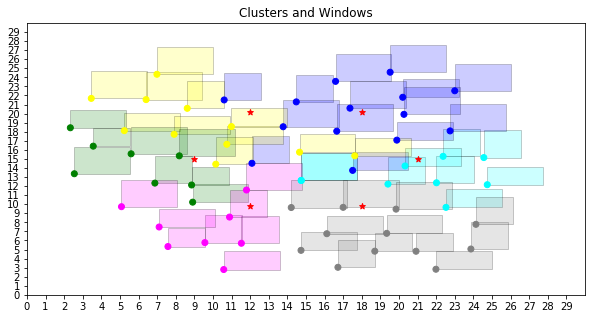

In [12]:
graphics.draw_windows(clusters, X_final, points_dims, points[:,4], n_groups, size_groups, SCREEN_HEIGHT, SCREEN_WIDTH, SCALE)